In [1]:
# Paqueterías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re, unicodedata
from pathlib import Path


# Análisis de Seguridad Vial en CDMX (2019-2023)

## Estado del proyecto

### Implementado
1. Carga y limpieza de datos de accidentes INEGI ATUS 2019-2023
2. Ingeniería de características: fechahora, severidad, franjas horarias, categorías de severidad
3. Unificación de datasets anuales en dos conjuntos: 2019-2023 y 2022-2023
4. Filtrado a zona CDMX (edo=9)
5. Descarga y almacenamiento de red vial OSM mediante OSMnx
6. Construcción de cuadrículas y asignación de accidentes a celdas
7. Cálculo de métricas básicas por celda: accidentes_totales, accidentes_graves, severidad_total

### A completar en este notebook
1. Normalización de métricas y cálculo de índice de riesgo compuesto por celda
2. Análisis temporal: índice de riesgo por franja horaria y día de semana
3. Ponderación por año (mayor peso a años recientes)
4. Preparación de pipeline para trabajar con tramos de calle (snap a edges)
5. Visualizaciones unificadas: mapas de calor, top 20 zonas peligrosas, mapas por franja horaria

## Limpieza general

In [2]:
# Configuraciones generales
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid", palette="muted")

# Ruta base de los datos
def find_data_root(start: Path = Path.cwd(), folder_name: str = "Datos raw") -> Path:
    for p in [start, *start.parents]:
        candidate = p / folder_name
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError(f"No se encontró la carpeta '{folder_name}' desde {start}")

DATA_PATH = find_data_root()  # <- ahora no dependes de la CWD

def _pick_csv_for_year(year: int, data_path: Path = DATA_PATH) -> Path:
    """Localiza el CSV del año sin depender 100% del nombre exacto."""
    year_dir = data_path / str(year)
    if not year_dir.exists():
        raise FileNotFoundError(f"No existe la carpeta: {year_dir}")
    candidates = list(year_dir.glob("*.csv"))
    if not candidates:
        raise FileNotFoundError(f"No encontré CSVs en {year_dir}")
    with_year = [p for p in candidates if str(year) in p.stem]
    return (with_year[0] if with_year else candidates[0]).resolve()

def _robust_read_csv(path: Path) -> pd.DataFrame:
    """Lee con tolerancia a encoding y separador."""
    attempts = [
        ("latin1", ","), ("utf-8", ","), ("utf-8-sig", ","),
        ("latin1", ";"), ("utf-8", ";"), ("utf-8-sig", ";"),
        ("latin1", "\t"), ("utf-8", "\t")]
    last_err = None
    for enc, sep in attempts:
        try:
            pd.read_csv(path, encoding=enc, sep=sep, nrows=5, low_memory=False)
            df = pd.read_csv(path, encoding=enc, sep=sep, low_memory=False)
            print(f"Leído: {path.name} | encoding={enc} sep='{sep}' | shape={df.shape}")
            return df
        except Exception as e:
            last_err = e
    # Fallback con inferencia de separador
    try:
        df = pd.read_csv(path, engine="python", sep=None, low_memory=False)
        print(f"Leído (engine=python): {path.name} | shape={df.shape}")
        return df
    except Exception as e:
        raise last_err if last_err is not None else e

# Función para cargar un dataset por año
def cargar_datos(anio):
    """Carga el dataset de accidentes georreferenciados de un año específico."""
    csv_path = _pick_csv_for_year(anio)
    print(f" Archivo seleccionado: {csv_path}")
    df = _robust_read_csv(csv_path)
    df["AÑO"] = anio  # Añadir columna de año
    return df

# Función para explorar un dataset de manera general
def explorar_datos(df):
    """Muestra información general del dataset."""
    print(" Dimensiones:", df.shape)
    print("\n Tipos de datos:\n", df.dtypes)
    print("\n Valores nulos por columna:\n", df.isnull().sum())
    print("\n Proporción de valores nulos por columna:\n", df.isnull().mean())
    print("\n Descripción numérica:\n", df.describe())
    print("\n Muestra de registros:")
    display(df.head(3))



In [3]:
# Función para limpiar datasets
def limpiar_datos(df):
    """Estandariza columnas, limpia duplicados, normaliza texto."""
    # Normalizar nombres de columnas
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    
    # Eliminar duplicados
    before = df.shape[0]
    df = df.drop_duplicates()
    after = df.shape[0]
    if before != after:
        print(f" Se eliminaron {before - after} duplicados.")
    
    # Normalizar strings
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype(str).str.strip().str.upper()
    
    # Reemplazar valores nulos genéricos
    #df.replace(["NA", "N/A", "-", "SIN INFORMACION"], np.nan, inplace=True)
    
    return df


In [4]:
# Función para guardar el dataset limpio
CASI_LIMPIOS_DIR = (Path(DATA_PATH).parent / "Datos limpios").resolve()
def guardar_casi_limpio(df, anio, nombre=f"ACCIDENTES_LIMPIO_{{anio}}.csv", por_anio=True):
    """
    Guarda el dataset en 'Datos casi limpios' 
    """
    CASI_LIMPIOS_DIR.mkdir(parents=True, exist_ok=True)
    subdir = CASI_LIMPIOS_DIR / str(anio) if por_anio else CASI_LIMPIOS_DIR
    subdir.mkdir(parents=True, exist_ok=True)

    out_path = subdir / nombre.format(anio=anio)
    df.to_csv(out_path, index=False, encoding="utf-8")
    print(f"Archivo casi limpio guardado en: {out_path}")

In [5]:
for anio in [2019, 2020, 2021, 2022, 2023]:
    df = cargar_datos(anio) 
    df = limpiar_datos(df)
    guardar_casi_limpio(df, anio)


 Archivo seleccionado: C:\Users\Jhoshua\Downloads\Proyecto Final Minería\ProyectoMineria\Datos raw\2019\BASE MUNICIPAL_ACCIDENTES DE TRANSITO GEORREFERENCIADOS_2019.csv
Leído: BASE MUNICIPAL_ACCIDENTES DE TRANSITO GEORREFERENCIADOS_2019.csv | encoding=latin1 sep=',' | shape=(180219, 49)
Archivo casi limpio guardado en: C:\Users\Jhoshua\Downloads\Proyecto Final Minería\ProyectoMineria\Datos limpios\2019\ACCIDENTES_LIMPIO_2019.csv
 Archivo seleccionado: C:\Users\Jhoshua\Downloads\Proyecto Final Minería\ProyectoMineria\Datos raw\2020\BASE MUNICIPAL_ACCIDENTES DE TRANSITO GEORREFERENCIADOS_2020.csv
Leído: BASE MUNICIPAL_ACCIDENTES DE TRANSITO GEORREFERENCIADOS_2020.csv | encoding=latin1 sep=',' | shape=(150886, 49)
Archivo casi limpio guardado en: C:\Users\Jhoshua\Downloads\Proyecto Final Minería\ProyectoMineria\Datos limpios\2020\ACCIDENTES_LIMPIO_2020.csv
 Archivo seleccionado: C:\Users\Jhoshua\Downloads\Proyecto Final Minería\ProyectoMineria\Datos raw\2021\BASE MUNICIPAL_ACCIDENTES DE T

## Revisión y mejora de limpieza

In [6]:
# Carga y revisión
anio = 2023  # >>>
df = cargar_datos(anio)
df = limpiar_datos(df)

print(f"Dataset {anio} cargado. Filas: {df.shape[0]} | Columnas: {df.shape[1]}")
explorar_datos(df)


 Archivo seleccionado: C:\Users\Jhoshua\Downloads\Proyecto Final Minería\ProyectoMineria\Datos raw\2023\BASE MUNICIPAL_ACCIDENTES DE TRANSITO GEORREFERENCIADOS_2023.csv
Leído: BASE MUNICIPAL_ACCIDENTES DE TRANSITO GEORREFERENCIADOS_2023.csv | encoding=latin1 sep=',' | shape=(262768, 50)
Dataset 2023 cargado. Filas: 262768 | Columnas: 51
 Dimensiones: (262768, 51)

 Tipos de datos:
 id             object
edo             int64
mes             int64
anio            int64
mpio            int64
hora            int64
minutos         int64
dia             int64
diasemana       int64
urbana          int64
suburbana       int64
tipaccid        int64
automovil       int64
campasaj        int64
microbus        int64
pascamion       int64
omnibus         int64
tranvia         int64
camioneta       int64
camion          int64
tractor         int64
ferrocarri      int64
motociclet      int64
bicicleta       int64
otrovehic       int64
causaacci       int64
caparod         int64
sexo            int64

,id,edo,mes,anio,mpio,hora,minutos,dia,diasemana,urbana,suburbana,tipaccid,automovil,campasaj,microbus,pascamion,omnibus,tranvia,camioneta,camion,tractor,ferrocarri,motociclet,bicicleta,otrovehic,causaacci,caparod,sexo,aliento,cinturon,edad,condmuerto,condherido,pasamuerto,pasaherido,peatmuerto,peatherido,ciclmuerto,ciclherido,otromuerto,otroherido,totmuertos,totheridos,clase,calle1,calle2,carretera,longitud,latitud,oid,año
0,1084046-619-174487611,1,1,2023,1,0,0,1,7,0,2,3,1,0,0,0,0,0,0,0,0,0,0,0,0,4,1,2,6,9,41,0,1,0,0,0,0,0,0,0,0,0,1,2,SAN NICOLÁS DE ARRIBA - PUERTECITO DE LA VIRGEN,NAN,NAN,-102.217242,21.959514,1,2023
1,1084037-112-190828175,1,1,2023,1,2,20,1,7,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,4,9,46,0,0,0,0,0,0,0,0,0,0,0,0,3,SIGLO XXI,HACIENDA SALTO DE LOS SALADOS,NAN,-102.250662,21.886193,2,2023
2,1084037-112-190828160,1,1,2023,1,3,20,1,7,1,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,5,9,27,1,0,0,1,0,0,0,0,0,0,1,1,1,HÉROE DE NACOZARI NORTE,INDEPENDENCIA DE MÉXICO,NAN,-102.284852,21.890967,3,2023


In [7]:
# Revisión de calidad de datos
def revisar_calidad(df):
    print(" Revisión general de calidad\n")
    print("Duplicados:", df.duplicated().sum())
    print("\nTop 10 columnas con más nulos:")
    display(df.isnull().mean().sort_values(ascending=False).head(10))
    print("\nResumen de tipos:")
    display(df.dtypes.value_counts())
    print("\nValores únicos en algunas columnas categóricas:")
    for col in df.columns:
        print(f"- {col}: {df[col].nunique()} valores únicos")

revisar_calidad(df)


 Revisión general de calidad

Duplicados: 0

Top 10 columnas con más nulos:


id            0.0
ciclherido    0.0
aliento       0.0
cinturon      0.0
edad          0.0
condmuerto    0.0
condherido    0.0
pasamuerto    0.0
pasaherido    0.0
peatmuerto    0.0
dtype: float64


Resumen de tipos:


int64      45
object      4
float64     2
Name: count, dtype: int64


Valores únicos en algunas columnas categóricas:
- id: 262768 valores únicos
- edo: 32 valores únicos
- mes: 12 valores únicos
- anio: 1 valores únicos
- mpio: 87 valores únicos
- hora: 25 valores únicos
- minutos: 61 valores únicos
- dia: 32 valores únicos
- diasemana: 8 valores únicos
- urbana: 3 valores únicos
- suburbana: 4 valores únicos
- tipaccid: 12 valores únicos
- automovil: 10 valores únicos
- campasaj: 6 valores únicos
- microbus: 4 valores únicos
- pascamion: 5 valores únicos
- omnibus: 5 valores únicos
- tranvia: 2 valores únicos
- camioneta: 7 valores únicos
- camion: 6 valores únicos
- tractor: 5 valores únicos
- ferrocarri: 3 valores únicos
- motociclet: 9 valores únicos
- bicicleta: 4 valores únicos
- otrovehic: 6 valores únicos
- causaacci: 5 valores únicos
- caparod: 2 valores únicos
- sexo: 3 valores únicos
- aliento: 3 valores únicos
- cinturon: 3 valores únicos
- edad: 89 valores únicos
- condmuerto: 4 valores únicos
- condherido: 7 valores únicos
- pasamuerto: 5

In [8]:
# Utils para graficar distribuciones y correlaciones

def plot_accidentes_por_hora(df, col='hora', clip_out_of_range=True):
    if col not in df.columns:
        print(f"Columna '{col}' no existe.")
        return
    
    serie = df[col].dropna()
    # Opcional: limitar a 0..23 si hay valores fuera de rango
    if clip_out_of_range:
        fuera = serie[(serie < 0) | (serie > 23)].shape[0]
        if fuera > 0:
            print(f" {fuera} valores fuera de 0–23 serán ignorados.")
        serie = serie[(serie >= 0) & (serie <= 23)]

    total = len(serie)
    bins = np.arange(0, 25, 1)  # 0..24 => 24 bins
    fig, ax = plt.subplots(figsize=(10, 4))
    counts, edges, patches = ax.hist(serie, bins=bins, align='left', rwidth=0.9)
    ax.set_title('Accidentes por hora')
    ax.set_xlabel('Hora del día')
    ax.set_ylabel('Conteo')
    ax.set_xticks(np.arange(0, 24, 1))
    ax.set_xlim(-0.5, 23.5)
    ax.grid(axis='y', alpha=0.3)

    # Eje secundario con porcentaje
    ax2 = ax.twinx()
    ax2.set_ylabel('% sobre el total')
    ax2.set_ylim(0, (counts.max() / total) * 100 * 1.2 if total else 1)

    # Anotaciones de conteo y %
    for x, c in enumerate(counts):
        if c > 0:
            ax.text(x, c, f"{int(c)}", ha='center', va='bottom', fontsize=8, rotation=0)
            ax2.text(x, (c/total)*100, f"{(c/total)*100:.1f}%", ha='center', va='bottom', fontsize=7, rotation=0)

    fig.tight_layout()
    plt.show()

def plot_accidentes_por_dia_semana(df, col='diasemana', mapping=None):
    """
    mapping: dict opcional, p. ej. {1:'L',2:'M',3:'X',4:'J',5:'V',6:'S',7:'D'}
    Si no se pasa mapping, intenta detectar 0..6 o 1..7 y ordenarlos.
    """
    if col not in df.columns:
        print(f"Columna '{col}' no existe.")
        return
    
    serie = df[col].dropna().astype(int)
    total = len(serie)
    valores = sorted(serie.unique())
    
    # Heurística de etiquetas
    # Prioriza 1..7; si parece 0..6, ajusta
    if mapping is None:
        if set(valores).issuperset({1,2,3,4,5,6,7}):
            orden = [1,2,3,4,5,6,7]
            etiquetas = ['L', 'M', 'X', 'J', 'V', 'S', 'D']  # Lunes-Domingo
        elif set(valores).issuperset({0,1,2,3,4,5,6}):
            orden = [0,1,2,3,4,5,6]
            etiquetas = ['L', 'M', 'X', 'J', 'V', 'S', 'D']  # asumiendo 0=Lunes
        else:
            orden = valores
            etiquetas = [str(v) for v in orden]
    else:
        # usar mapping y ordenarlo por L->D si posible
        orden = [k for k in mapping.keys() if k in valores]
        etiquetas = [mapping[k] for k in orden]

    conteo = serie.value_counts().reindex(orden).fillna(0).astype(int)
    porcentaje = (conteo / total * 100) if total else conteo

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(range(len(conteo)), conteo.values)
    ax.set_title('Accidentes por día de la semana')
    ax.set_xlabel('Día')
    ax.set_ylabel('Conteo')
    ax.set_xticks(range(len(conteo)))
    ax.set_xticklabels(etiquetas)
    ax.grid(axis='y', alpha=0.3)

    # Añadir porcentaje arriba de cada barra
    for i, (c, p) in enumerate(zip(conteo.values, porcentaje.values)):
        if c > 0:
            ax.text(i, c, f"{c}\n({p:.1f}%)", ha='center', va='bottom', fontsize=8)

    fig.tight_layout()
    plt.show()

def plot_matriz_hora_dia(df, col_hora='hora', col_dia='diasemana', mapping=None):
    """
    Muestra una matriz de calor con conteos de accidentes por hora y día de la semana
    """
    if (col_hora not in df.columns) or (col_dia not in df.columns):
        print("Faltan columnas requeridas.")
        return
    
    tmp = df[[col_hora, col_dia]].dropna().copy()
    tmp[col_hora] = tmp[col_hora].astype(int)
    tmp = tmp[(tmp[col_hora] >= 0) & (tmp[col_hora] <= 23)]

    # Orden días
    vals = sorted(tmp[col_dia].astype(int).unique())
    if mapping is None:
        if set(vals).issuperset({1,2,3,4,5,6,7}):
            orden_dias = [1,2,3,4,5,6,7]
            etiquetas_dias = ['L','M','X','J','V','S','D']
        elif set(vals).issuperset({0,1,2,3,4,5,6}):
            orden_dias = [0,1,2,3,4,5,6]
            etiquetas_dias = ['L','M','X','J','V','S','D']
        else:
            orden_dias = vals
            etiquetas_dias = [str(v) for v in orden_dias]
    else:
        orden_dias = [k for k in mapping.keys() if k in vals]
        etiquetas_dias = [mapping[k] for k in orden_dias]

    # Tabla de conteos (día x hora)
    tabla = (tmp.groupby([col_dia, col_hora]).size()
             .unstack(fill_value=0)
             .reindex(index=orden_dias, columns=range(24), fill_value=0))

    fig, ax = plt.subplots(figsize=(12, 4.5))
    im = ax.imshow(tabla.values, aspect='auto', origin='upper')
    ax.set_title('Matriz de accidentes (día × hora)')
    ax.set_xlabel('Hora')
    ax.set_ylabel('Día')
    ax.set_xticks(range(0,24,1))
    ax.set_yticks(range(len(orden_dias)))
    ax.set_yticklabels(etiquetas_dias)

    # Barra de color (conteo)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Conteo')

    fig.tight_layout()
    plt.show()

def plot_tendencias_temporales(
    df,
    col_anio='anio',
    col_mes='mes',
    col_dia=None,     # si tienes día del mes (1-31), pásalo para la serie diaria
    suavizar_mm=7     # ventana de media móvil para la serie diaria
):
    # Validaciones
    if col_anio not in df.columns or col_mes not in df.columns:
        print("Faltan columnas de tiempo (anio/mes).")
        return

    # Serie mensual
    tmp_m = df[[col_anio, col_mes]].dropna().copy()
    tmp_m[col_anio] = tmp_m[col_anio].astype(int)
    tmp_m[col_mes] = tmp_m[col_mes].astype(int).clip(1, 12)
    mensual = (tmp_m
               .assign(fecha=lambda x: pd.to_datetime(dict(year=x[col_anio], month=x[col_mes], day=1), errors='coerce'))
               .groupby('fecha').size().sort_index())

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(mensual.index, mensual.values, marker='o')
    ax.set_title('Accidentes por mes')
    ax.set_xlabel('Mes')
    ax.set_ylabel('Conteo')
    ax.grid(True, alpha=0.3)

    # Variación % intermensual
    if len(mensual) > 1:
        var_pct = mensual.pct_change() * 100
        ax2 = ax.twinx()
        ax2.plot(mensual.index, var_pct.values, linestyle='--')
        ax2.set_ylabel('Variación % m/m')
    fig.tight_layout()
    plt.show()

    # Serie diaria (opcional si tienes col_dia)
    if col_dia and (col_dia in df.columns):
        tmp_d = df[[col_anio, col_mes, col_dia]].dropna().copy()
        tmp_d[col_anio] = tmp_d[col_anio].astype(int)
        tmp_d[col_mes] = tmp_d[col_mes].astype(int).clip(1, 12)
        tmp_d[col_dia] = tmp_d[col_dia].astype(int).clip(1, 31)
        tmp_d['fecha'] = pd.to_datetime(dict(year=tmp_d[col_anio], month=tmp_d[col_mes], day=tmp_d[col_dia]),
                                        errors='coerce')
        diaria = tmp_d.groupby('fecha').size().sort_index()

        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(diaria.index, diaria.values, linewidth=1)
        ax.set_title('Accidentes por día (con media móvil)')
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Conteo diario')
        ax.grid(True, alpha=0.3)

        # Media móvil
        if len(diaria) >= suavizar_mm:
            mm = diaria.rolling(suavizar_mm, min_periods=1).mean()
            ax.plot(mm.index, mm.values)
        fig.tight_layout()
        plt.show()

def plot_severidad(df,
                   col_muertos='totmuertos',
                   col_heridos='totheridos',
                   desglosar_por=None  # por ejemplo 'clase' o 'tipaccid'
                   ):
    # Barras simples de totales
    cols_ok = [c for c in [col_muertos, col_heridos] if c in df.columns]
    if not cols_ok:
        print("No encuentro columnas de severidad.")
        return

    totales = {c: np.nan_to_num(df[c]).sum() for c in cols_ok}
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(list(totales.keys()), list(totales.values()))
    ax.set_title('Severidad total (suma de registros)')
    ax.set_ylabel('Total')
    for i, v in enumerate(totales.values()):
        ax.text(i, v, f"{int(v)}", ha='center', va='bottom')
    ax.grid(axis='y', alpha=0.3)
    fig.tight_layout()
    plt.show()

    # Desglose por categoría (stacked bars)
    if desglosar_por and desglosar_por in df.columns and len(cols_ok) == 2:
        # Sanitizar valores y agrupar top categorías
        gcol = desglosar_por
        # Top 10 categorías por frecuencia
        top_vals = df[gcol].value_counts().head(10).index
        sub = df[df[gcol].isin(top_vals)].copy()

        # Asegurar numérico
        sub[col_muertos] = pd.to_numeric(sub[col_muertos], errors='coerce').fillna(0)
        sub[col_heridos] = pd.to_numeric(sub[col_heridos], errors='coerce').fillna(0)

        tabla = (sub.groupby(gcol)[[col_muertos, col_heridos]].sum()
                 .sort_values(col_heridos, ascending=False))

        fig, ax = plt.subplots(figsize=(12, 5))
        indices = np.arange(len(tabla))
        ax.bar(indices, tabla[col_heridos].values, label='Heridos')
        ax.bar(indices, tabla[col_muertos].values, bottom=tabla[col_heridos].values, label='Muertos')
        ax.set_xticks(indices)
        ax.set_xticklabels(tabla.index, rotation=45, ha='right')
        ax.set_title(f"Severidad por {gcol} (Top 10)")
        ax.set_ylabel('Total')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        fig.tight_layout()
        plt.show()

def _numeric_continuas(df, min_unique=5, id_regex=r'(^id$|id_|_id$|^oid$|folio|guid)', max_unique_ratio=0.95):
    """
    Heurística para seleccionar variables numéricas continuas:
    - tipo numérico
    - no parecen IDs por nombre (regex)
    - no tienen cardinalidad ~igual al número de filas (IDs encubiertos)
    - al menos min_unique valores distintos
    """
    cols = []
    n = len(df)
    for c in df.select_dtypes(include='number').columns:
        name = c.lower()
        nunq = df[c].nunique(dropna=True)
        if re.search(id_regex, name):
            continue
        if n > 0 and nunq / max(1, n) >= max_unique_ratio:
            # probablemente un identificador
            continue
        if nunq < min_unique:
            # probablemente categórica codificada
            continue
        cols.append(c)
    return cols

def _cluster_order(corr):
    """
    Reordenamiento por clustering jerárquico.
    Si scipy no está disponible, reordena por la carga del 1er componente (PCA rústico).
    """
    try:
        from scipy.cluster.hierarchy import linkage, leaves_list
        from scipy.spatial.distance import squareform
        import numpy as np

        # Matriz de distancias a partir de la correlación
        D = 1 - corr.values
        np.fill_diagonal(D, 0.0)
        D = np.clip(D, 0, 2)
        D = np.where(np.isnan(D), 1.0, D)

        # ¡Clave!: convertir a vector “condensed” para linkage
        Dc = squareform(D, checks=False)

        Z = linkage(Dc, method='average')
        order = leaves_list(Z)
        return list(corr.columns[order])
    except Exception:
        # Fallback: ordenar por correlación media absoluta
        scores = corr.abs().mean().sort_values(ascending=False)
        return list(scores.index)

def plot_mapa_correlaciones(
    df: pd.DataFrame,
    top_n: int | None = None,
    method: str = 'pearson',     # 'pearson' | 'spearman' | 'kendall'
    triangular: str = 'lower',   # 'lower' | 'upper' | 'full'
    anotar: bool = False,        # escribe coeficientes en cada celda (mejor para <= 20)
    reordenar: bool = True,
    figsize=(10, 8),
    vmin=-1, vmax=1
):
    """
    Dibuja un heatmap de correlaciones con matplotlib.
    - top_n: si se indica, toma las top_n columnas por varianza.
    - triangular: 'lower', 'upper' o 'full'.
    """

    # 1) Selección de columnas numéricas continuas (evitar IDs)
    cols = _numeric_continuas(df)
    if not cols:
        print("No se encontraron columnas numéricas continuas adecuadas para correlación.")
        return

    # 2) Reducir a top_n por varianza (opcional)
    sub = df[cols].copy()
    if top_n is not None and top_n < len(cols):
        var_order = sub.var(numeric_only=True).sort_values(ascending=False).index.tolist()
        cols = var_order[:top_n]
        sub = sub[cols]

    # 3) Matriz de correlación
    corr = sub.corr(method=method)

    # 4) Reordenar (clustering o por importancia)
    if reordenar:
        ordered = _cluster_order(corr)
        corr = corr.loc[ordered, ordered]

    # 5) Aplicar máscara triangular si procede
    mask = np.zeros_like(corr, dtype=bool)
    if triangular == 'lower':
        mask = np.triu(np.ones_like(corr, dtype=bool), k=1)  # ocultar superior
    elif triangular == 'upper':
        mask = np.tril(np.ones_like(corr, dtype=bool), k=-1) # ocultar inferior
    # 'full' -> sin máscara

    # 6) Plot
    fig, ax = plt.subplots(figsize=figsize)
    mat = corr.mask(mask) if triangular in ('lower','upper') else corr
    im = ax.imshow(mat, vmin=vmin, vmax=vmax, aspect='auto')

    # Ticks y etiquetas
    ax.set_xticks(range(len(corr.columns)))
    ax.set_yticks(range(len(corr.index)))
    ax.set_xticklabels(corr.columns, rotation=45, ha='right')
    ax.set_yticklabels(corr.index)

    ax.set_title(f"Matriz de correlaciones ({method})")
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Coeficiente')

    # Cuadrícula ligera
    ax.set_xticks(np.arange(-0.5, len(corr.columns), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(corr.index), 1), minor=True)
    ax.grid(which='minor', color='w', linewidth=0.5, alpha=0.5)
    ax.tick_params(which='minor', bottom=False, left=False)

    # 7) Anotaciones (opcional)
    if anotar and len(corr) <= 20:
        for i in range(len(corr.index)):
            for j in range(len(corr.columns)):
                if triangular == 'lower' and j > i: 
                    continue
                if triangular == 'upper' and j < i:
                    continue
                val = corr.iloc[i, j]
                if pd.notna(val):
                    ax.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=8)

    fig.tight_layout()
    plt.show()



,mean,std,min,25%,50%,75%,max
edo,16.596892,7.690275,1.0,10.0,19.0,21.0,32.0
mes,6.637631,3.433981,1.0,4.0,7.0,10.0,12.0
mpio,34.061374,31.569448,1.0,14.0,30.0,39.0,385.0
hora,13.129913,5.917478,0.0,9.0,14.0,18.0,99.0
minutos,26.283726,17.714297,0.0,10.0,27.0,40.0,99.0
dia,15.675337,8.795247,1.0,8.0,16.0,23.0,32.0
diasemana,3.993420,1.978127,1.0,2.0,4.0,6.0,8.0
tipaccid,2.952764,3.328803,1.0,1.0,1.0,4.0,12.0
automovil,1.295763,0.754323,0.0,1.0,1.0,2.0,9.0
campasaj,0.183812,0.444133,0.0,0.0,0.0,0.0,5.0


 7 valores fuera de 0–23 serán ignorados.


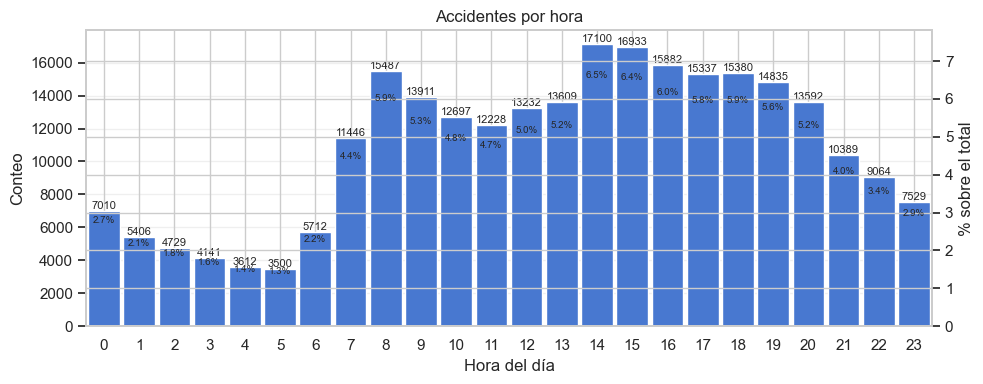

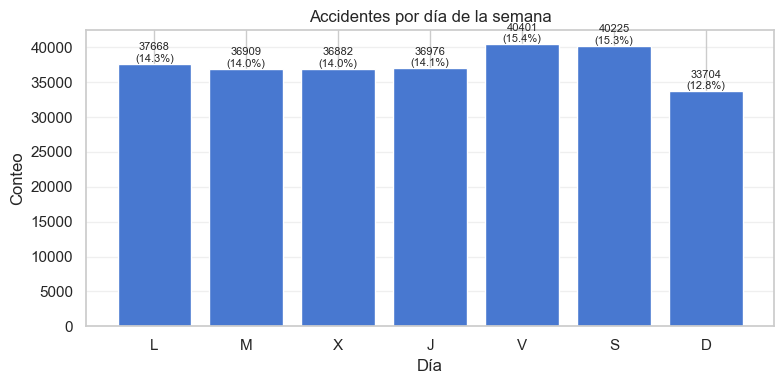

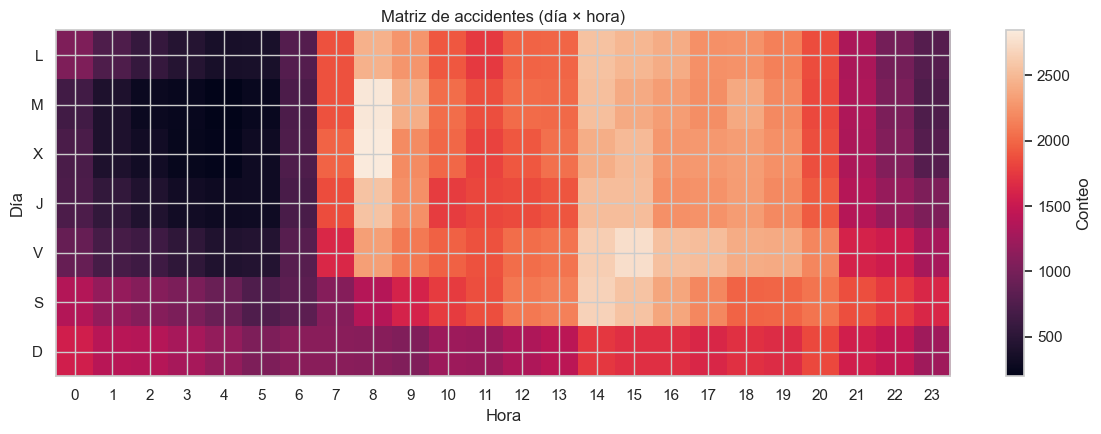

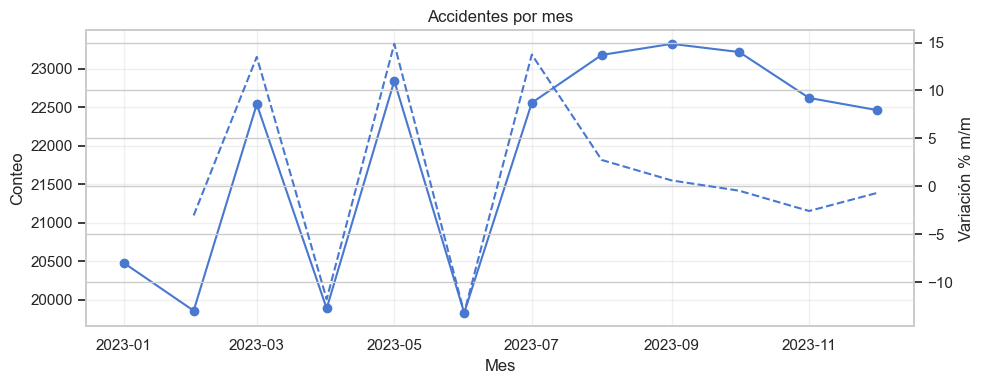

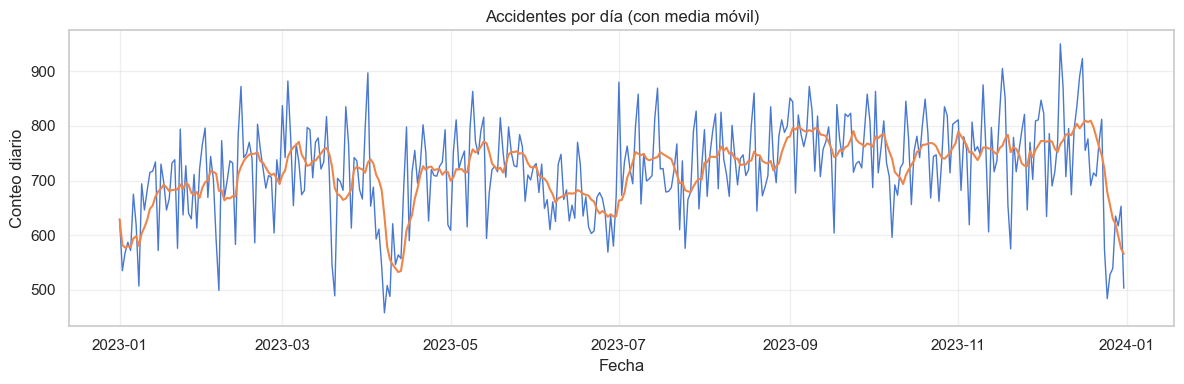

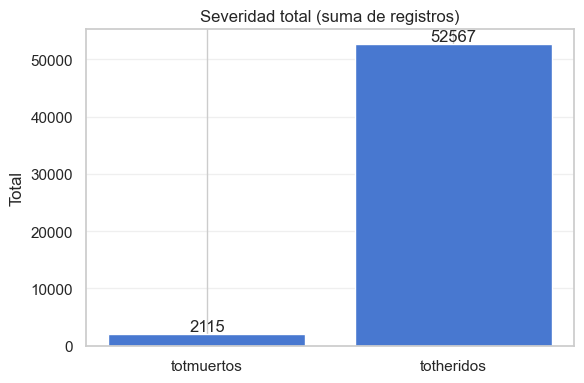

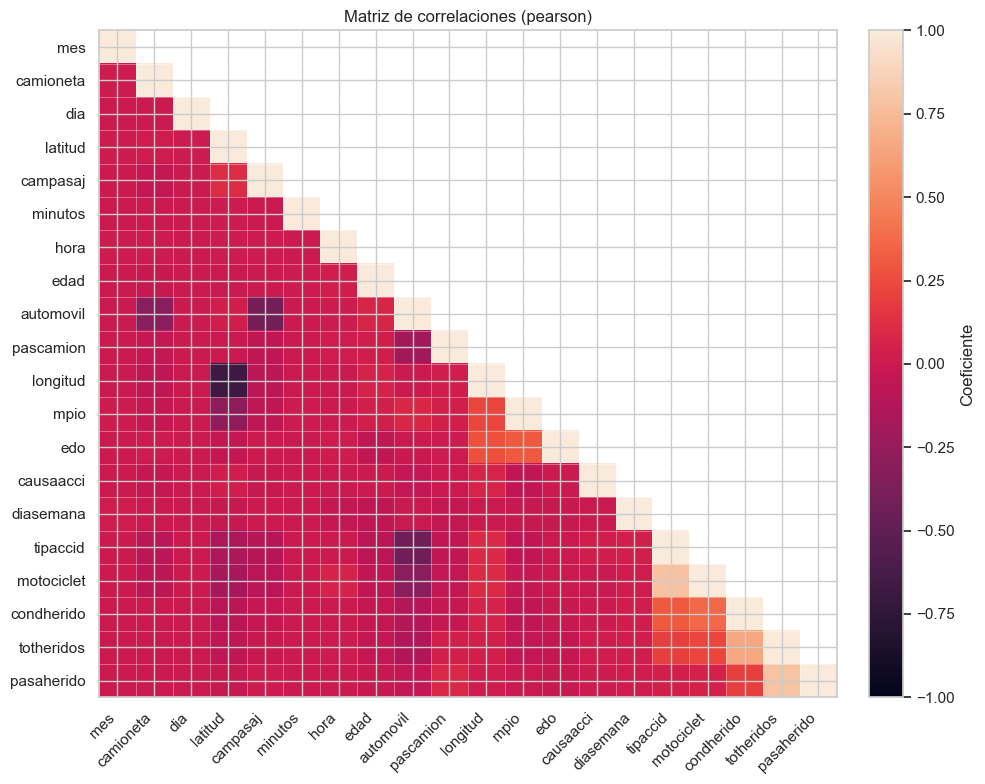

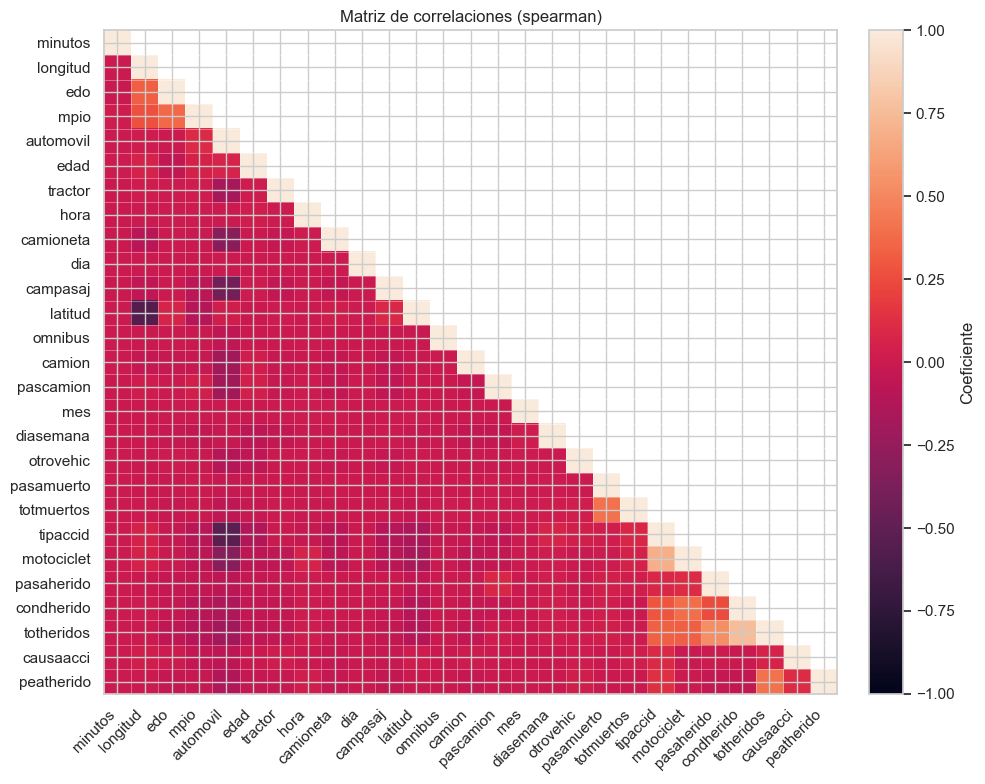

In [9]:
# Revisión estadística y gráficos
import matplotlib.pyplot as plt

def revisar_nulos_y_outliers(df):

    # Descripción rápida de variables numéricas
    num_cols = [c for c in df.select_dtypes(include='number').columns if df[c].nunique() > 5]
    resumen = df[num_cols].describe().T[['mean','std','min','25%','50%','75%','max']]
    display(resumen.head(10))

    # Distribución rápida de accidentes por hora y día
    if 'hora' in df.columns:
        plot_accidentes_por_hora(df, col='hora')

    if 'diasemana' in df.columns:
       mapping = {1:'L',2:'M',3:'X',4:'J',5:'V',6:'S',7:'D'}
       plot_accidentes_por_dia_semana(df, mapping=mapping)

    plot_matriz_hora_dia(df, mapping=mapping)
    plot_tendencias_temporales(df, col_anio='anio', col_mes='mes', col_dia='dia', suavizar_mm=7)

    # Totales
    plot_severidad(df, col_muertos='totmuertos', col_heridos='totheridos')


    plot_mapa_correlaciones(df, top_n=20, triangular='lower', reordenar=True)
    plot_mapa_correlaciones(df, method='spearman', triangular='lower')

revisar_nulos_y_outliers(df)


In [10]:
df.loc[(df['hora'] < 0) | (df['hora'] > 23), ['id', 'anio', 'mes', 'dia', 'hora']]


,id,anio,mes,dia,hora
74460,1108781-999-377,2023,9,30,99
74461,1108781-999-375,2023,9,30,99
74462,1108781-999-376,2023,9,30,99
74463,1108781-999-374,2023,9,30,99
200236,1125418-999-30,2023,5,19,99
204700,1108860-999-45,2023,9,16,99
220781,1101311-999-33,2023,7,4,99


## Ingienería de datos y merge

In [11]:
import pandas as pd
import numpy as np
import os

In [12]:
# Carga de los datos limpios
df_2019 = pd.read_csv("Datos limpios/2019/ACCIDENTES_LIMPIO_2019.csv",low_memory=False)
df_2020 = pd.read_csv("Datos limpios/2020/ACCIDENTES_LIMPIO_2020.csv",low_memory=False)
df_2021 = pd.read_csv("Datos limpios/2021/ACCIDENTES_LIMPIO_2021.csv")
df_2022 = pd.read_csv("Datos limpios/2022/ACCIDENTES_LIMPIO_2022.csv")
df_2023 = pd.read_csv("Datos limpios/2023/ACCIDENTES_LIMPIO_2023.csv")


In [13]:
dfs = {2019: df_2019, 2020: df_2020, 2021: df_2021, 2022: df_2022, 2023: df_2023}

# Ver columnas de cada año
for year, df in dfs.items():
    print(f"Columnas {year}:")
    print(list(df.columns))
    print()

# Detectar columnas comunes y columnas que faltan en algunos años
cols_por_year = {year: set(df.columns) for year, df in dfs.items()}
todas_cols = sorted(set().union(*cols_por_year.values()))
cols_comunes = sorted(set.intersection(*cols_por_year.values()))

print("Columnas comunes a todos los años:")
print(cols_comunes)
print()

print("Columnas que no están en todos los años:")
for col in todas_cols:
    años_con_col = [year for year, cols in cols_por_year.items() if col in cols]
    if len(años_con_col) != len(dfs):
        print(f"{col}: aparece en {años_con_col}")

Columnas 2019:
['id', 'edo', 'mes', 'anio', 'mpio', 'hora', 'minutos', 'dia', 'diasemana', 'urbana', 'suburbana', 'tipaccid', 'automovil', 'campasaj', 'microbus', 'pascamion', 'omnibus', 'tranvia', 'camioneta', 'camion', 'tractor', 'ferrocarri', 'motociclet', 'bicicleta', 'otrovehic', 'causaacci', 'caparod', 'sexo', 'aliento', 'cinturon', 'edad', 'condmuerto', 'condherido', 'pasamuerto', 'pasaherido', 'peatmuerto', 'peatherido', 'ciclmuerto', 'ciclherido', 'otromuerto', 'otroherido', 'totmuertos', 'totheridos', 'clase', 'calle1', 'calle2', 'carretera', 'longitud', 'latitud', 'año']

Columnas 2020:
['id', 'edo', 'mes', 'anio', 'mpio', 'hora', 'minutos', 'dia', 'diasemana', 'urbana', 'suburbana', 'tipaccid', 'automovil', 'campasaj', 'microbus', 'pascamion', 'omnibus', 'tranvia', 'camioneta', 'camion', 'tractor', 'ferrocarri', 'motociclet', 'bicicleta', 'otrovehic', 'causaacci', 'caparod', 'sexo', 'aliento', 'cinturon', 'edad', 'condmuerto', 'condherido', 'pasamuerto', 'pasaherido', 'peat

In [14]:
# Dropear 'oid' y armonizar la columna de año
for year, df in dfs.items():
    if "oid" in df.columns:
        df.drop(columns="oid", inplace=True)
    
    # Unificar a una sola columna llamada 'anio'
    if "anio" not in df.columns and "año" in df.columns:
        df.rename(columns={"año": "anio"}, inplace=True)
    if "año" in df.columns and "anio" in df.columns:
        df.drop(columns="año", inplace=True)
    
    # Asegurar que la columna 'anio' tenga el año correcto
    df["anio"] = year

# Unir 2019–2023
df_2019_2023 = pd.concat([dfs[y] for y in range(2019, 2024)], ignore_index=True)

# Unir 2022–2023
df_2022_2023 = pd.concat([dfs[y] for y in (2022, 2023)], ignore_index=True)

# Revisar tamaños
print(df_2019_2023.shape, df_2022_2023.shape)


(1043988, 49) (513659, 49)


In [15]:
def checar_consistencia(df, nombre="df"):
    cols_muertos = ["condmuerto", "pasamuerto", "peatmuerto", "ciclmuerto", "otromuerto"]
    cols_heridos = ["condherido", "pasaherido", "peatherido", "ciclherido", "otroherido"]

    tmp = df.copy()
    tmp[cols_muertos + ["totmuertos"]] = tmp[cols_muertos + ["totmuertos"]].fillna(0)
    tmp[cols_heridos + ["totheridos"]] = tmp[cols_heridos + ["totheridos"]].fillna(0)

    diff_muertos = tmp[cols_muertos].sum(axis=1) - tmp["totmuertos"]
    diff_heridos = tmp[cols_heridos].sum(axis=1) - tmp["totheridos"]

    print(f"Chequeo en {nombre}")
    print("Filas donde condmuerto+pasamuerto+peatmuerto+ciclmuerto+otromuerto ≠ totmuertos:",
          (diff_muertos != 0).sum())
    print("Filas donde condherido+pasaherido+peatherido+ciclherido+otroherido ≠ totheridos:",
          (diff_heridos != 0).sum())
    
    return diff_muertos, diff_heridos
diff_muertos_2019_2023, diff_heridos_2019_2023 = checar_consistencia(df_2019_2023, "2019-2023")
diff_muertos_2022_2023, diff_heridos_2022_2023 = checar_consistencia(df_2022_2023, "2022-2023")


Chequeo en 2019-2023
Filas donde condmuerto+pasamuerto+peatmuerto+ciclmuerto+otromuerto ≠ totmuertos: 0
Filas donde condherido+pasaherido+peatherido+ciclherido+otroherido ≠ totheridos: 0
Chequeo en 2022-2023
Filas donde condmuerto+pasamuerto+peatmuerto+ciclmuerto+otromuerto ≠ totmuertos: 0
Filas donde condherido+pasaherido+peatherido+ciclherido+otroherido ≠ totheridos: 0


In [16]:
# Un poco de ingienería de características

def agregar_fecha_y_severidad(df):
    # Fecha-hora combinada
    dt = df[["anio", "mes", "dia", "hora", "minutos"]].copy()
    dt.columns = ["year", "month", "day", "hour", "minute"]
    df["fechahora"] = pd.to_datetime(dt, errors="coerce")
    
    # Severidad numérica simple
    df["severidad"] = 10 * df["totmuertos"] + 3 * df["totheridos"]
    
    # Flags de severidad
    df["hay_muertos"] = df["totmuertos"] > 0
    df["hay_heridos"] = df["totheridos"] > 0
    df["solo_daños_materiales"] = (~df["hay_muertos"]) & (~df["hay_heridos"])
    
    # Severidad categórica
    def clasificar_severidad(row):
        if row["totmuertos"] >= 1:
            return "muy grave"
        if row["totheridos"] >= 3:
            return "grave"
        if row["totheridos"] >= 1:
            return "moderada"
        return "leve"
    
    df["severidad_cat"] = df.apply(clasificar_severidad, axis=1)
    
    # Franjas horarias (con hora 0–23)
    df["franja_horaria"] = pd.cut(
        df["hora"],
        bins=[-1, 5, 11, 17, 23],
        labels=["Madrugada", "Mañana", "Tarde", "Noche"])
    
    return df

# Aplicar a dataframes agregados
df_2019_2023 = agregar_fecha_y_severidad(df_2019_2023)
df_2022_2023 = agregar_fecha_y_severidad(df_2022_2023)

# De paso también a los anuales originales xd
dfs = {2019: df_2019, 2020: df_2020, 2021: df_2021, 2022: df_2022, 2023: df_2023}
for df in dfs.values():
    agregar_fecha_y_severidad(df)


In [17]:
print(df_2019_2023.shape, df_2022_2023.shape) # Agregamos 7 columnas

(1043988, 56) (513659, 56)


In [18]:
# Crear carpeta para los combinados
os.makedirs("Datos combinados", exist_ok=True)

# Actualizar los CSV limpios (sobrescribir)
rutas_anuales = {
    2019: "Datos limpios/2019/ACCIDENTES_LIMPIO_2019.csv",
    2020: "Datos limpios/2020/ACCIDENTES_LIMPIO_2020.csv",
    2021: "Datos limpios/2021/ACCIDENTES_LIMPIO_2021.csv",
    2022: "Datos limpios/2022/ACCIDENTES_LIMPIO_2022.csv",
    2023: "Datos limpios/2023/ACCIDENTES_LIMPIO_2023.csv",
}

dfs = {2019: df_2019, 2020: df_2020, 2021: df_2021, 2022: df_2022, 2023: df_2023}

for anio, df in dfs.items():
    df.to_csv(rutas_anuales[anio], index=False)   # sobrescribe el archivo

# Guardar los dataframes combinados en la nueva carpeta
df_2019_2023.to_csv("Datos combinados/ACCIDENTES_COMBINADO_2019_2023.csv", index=False)
df_2022_2023.to_csv("Datos combinados/ACCIDENTES_COMBINADO_2022_2023.csv", index=False)


# **Puntos negros**

In [19]:
import pandas as pd
import os

import osmnx as ox
# Para ver logs útiles:
ox.settings.log_console = True
ox.settings.use_cache = True 
import networkx as nx

## Filtramos a sólo CDMX

In [20]:
df_2019_2023 = pd.read_csv("Datos combinados/ACCIDENTES_COMBINADO_2019_2023.csv", parse_dates=["fechahora"], low_memory=False)  # combinado 2019–2023
df_2022_2023 = pd.read_csv("Datos combinados/ACCIDENTES_COMBINADO_2022_2023.csv", parse_dates=["fechahora"], low_memory=False)  # combinado 2022–2023


In [21]:
print("Columnas de df_2022_2023:")
print(list(df_2022_2023.columns))

Columnas de df_2022_2023:
['id', 'edo', 'mes', 'anio', 'mpio', 'hora', 'minutos', 'dia', 'diasemana', 'urbana', 'suburbana', 'tipaccid', 'automovil', 'campasaj', 'microbus', 'pascamion', 'omnibus', 'tranvia', 'camioneta', 'camion', 'tractor', 'ferrocarri', 'motociclet', 'bicicleta', 'otrovehic', 'causaacci', 'caparod', 'sexo', 'aliento', 'cinturon', 'edad', 'condmuerto', 'condherido', 'pasamuerto', 'pasaherido', 'peatmuerto', 'peatherido', 'ciclmuerto', 'ciclherido', 'otromuerto', 'otroherido', 'totmuertos', 'totheridos', 'clase', 'calle1', 'calle2', 'carretera', 'longitud', 'latitud', 'fechahora', 'severidad', 'hay_muertos', 'hay_heridos', 'solo_daños_materiales', 'severidad_cat', 'franja_horaria']


In [22]:
# Ver cómo está codificada la columna de estado
df_2019_2023["edo"].value_counts().sort_index()      # códigos de estado
print(df_2019_2023[["edo", "mpio"]].drop_duplicates().head(5))  # ejemplos de edo+municipio

df_2019_2023.groupby("edo")[["latitud", "longitud"]].mean().sort_index()




       edo  mpio
0        1     1
2681     2     1
6637     2     2
8581     3     3
10494    4     2


,latitud,longitud
edo,,
1,21.906809,-102.299533
2,32.239714,-116.463200
3,23.993240,-110.310893
4,19.168577,-91.245046
5,26.059678,-102.507148
6,19.203494,-103.891313
7,15.767936,-92.494174
8,28.793296,-106.146947
9,19.393246,-99.142029


In [23]:
df_2019_2023[df_2019_2023["edo"] == 9]["mpio"].nunique()          # número de alcaldías
df_2019_2023[df_2019_2023["edo"] == 9]["mpio"].sort_values().unique()  # claves de alcaldía


array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
      dtype=int64)

map_mpio_cdmx = {
    2: "Azcapotzalco",
    3: "Coyoacán",
    4: "Cuajimalpa de Morelos",
    5: "Gustavo A. Madero",
    6: "Iztacalco",
    7: "Iztapalapa",
    8: "La Magdalena Contreras",
    9: "Milpa Alta",
    10: "Álvaro Obregón",
    11: "Tláhuac",
    12: "Tlalpan",
    13: "Xochimilco",
    14: "Benito Juárez",
    15: "Cuauhtémoc",
    16: "Miguel Hidalgo",
    17: "Venustiano Carranza",
}

df_cdmx_2019_2023 = df_2019_2023[df_2019_2023["edo"] == 9].copy()
df_cdmx_2019_2023["alcaldia"] = df_cdmx_2019_2023["mpio"].map(map_mpio_cdmx)


In [24]:
df_cdmx_2019_2023 = df_2019_2023[df_2019_2023["edo"] == 9].copy()
df_cdmx_2022_2023 = df_2022_2023[df_2022_2023["edo"] == 9].copy()


In [25]:
# Crear carpeta para los combinados en CDMX
os.makedirs("Datos combinados CDMX", exist_ok=True)

# Guardar los dataframes combinados de CDMX en la nueva carpeta
df_cdmx_2019_2023.to_csv("Datos combinados CDMX/ACCIDENTES_COMBINADO_CDMX_2019_2023.csv", index=False)
df_cdmx_2022_2023.to_csv("Datos combinados CDMX/ACCIDENTES_COMBINADO_CDMX_2022_2023.csv", index=False)


## Red vial con OpenStreetMap

In [26]:
import osmnx as ox
import networkx as nx

In [ ]:
place_cdmx = "Ciudad de Mexico, Mexico"


# CREACION DEL GRAFO VIAL DIRIGIDO CON PARAMETROS OPTIMIZADOS

# Parametros explicados:
# - network_type="drive": Solo calles vehiculares (excluye peatonales)
# - retain_all=True: Mantiene todos los componentes del grafo (no solo el principal)
# - simplify=True: Simplifica intersecciones y elimina nodos redundantes
# - truncate_by_edge=True: Trunca el grafo por aristas completas (no corta a la mitad)
# - clean_periphery=True: Limpia nodos perifericos sueltos

print("Descargando red vial de CDMX...")
print("Parametros:")
print("  - network_type: drive (solo calles vehiculares)")
print("  - retain_all: True (todos los componentes)")
print("  - simplify: True (simplifica intersecciones)")
print("  - truncate_by_edge: True (aristas completas)")
print("  - clean_periphery: True (limpia periferia)")
print()

G_cdmx = ox.graph_from_place(
    place_cdmx, 
    network_type="drive",
    retain_all=True,
    simplify=True,
    truncate_by_edge=True,
)

print(f"[OK] Grafo descargado exitosamente")
print(f"  - Nodos: {len(G_cdmx.nodes):,}")
print(f"  - Aristas: {len(G_cdmx.edges):,}")
print(f"  - Tipo: {'Dirigido' if G_cdmx.is_directed() else 'No dirigido'}")

Descargando red vial de CDMX...
Parametros:
  - network_type: drive (solo calles vehiculares)
  - retain_all: True (todos los componentes)
  - simplify: True (simplifica intersecciones)
  - truncate_by_edge: True (aristas completas)
  - clean_periphery: True (limpia periferia)

[OK] Grafo descargado exitosamente
  - Nodos: 99,712
  - Aristas: 234,484
  - Tipo: Dirigido


In [28]:
# Verificamos 
type(G_cdmx), len(G_cdmx.nodes), len(G_cdmx.edges)

(networkx.classes.multidigraph.MultiDiGraph, 99712, 234484)

In [29]:
# Convertimos a geodataframes y exploramos un poco
nodes, edges = ox.graph_to_gdfs(G_cdmx)

print(nodes.shape)  # (n_nodos, n_columnas)
print(edges.shape)  # (n_aristas, n_columnas)

nodes.head()
edges.head()


(99712, 7)
(234484, 15)


osmid      highway lanes maxspeed  \
u        v         key                                          
30339493 274185917 0    226529202        trunk     4       80   
30339495 274187776 0    226529202        trunk     4       80   
         274188569 0    683249554  residential     1      NaN   
30339671 275512749 0    396108080  residential     4      NaN   
         274840978 0    569407579  residential     4      NaN   

                                            name  oneway       ref reversed  \
u        v         key                                                        
30339493 274185917 0    Calzada San Antonio Abad    True  RADIAL 3    False   
30339495 274187776 0    Calzada San Antonio Abad    True  RADIAL 3    False   
         274188569 0        Calle Juan A. Mateos    True       NaN    False   
30339671 275512749 0         Calle Matías Romero   False       NaN    False   
         274840978 0         Calle Matías Romero   False       NaN     True   

                            length  \
u        v         key               
30339493 274185917 0    143.774525   
30339495 274187776 0    119.143540   
         274188569 0     58.283138   
30339671 275512749 0     87.489342   
         274840978 0     12.831024   

                                                                 geometry  \
u        v         key                                                      
30339493 274185917 0    LINESTRING (-99.1341 19.41806, -99.13409 19.41...   
30339495 274187776 0    LINESTRING (-99.13533 19.41027, -99.13517 19.4...   
         274188569 0    LINESTRING (-99.13533 19.41027, -99.13483 19.4...   
30339671 275512749 0    LINESTRING (-99.15338 19.37858, -99.15256 19.3...   
         274840978 0    LINESTRING (-99.15338 19.37858, -99.1535 19.3786)   

                       width bridge tunnel junction access  
u        v         key                                      
30339493 274185917 0     NaN    NaN    NaN      NaN    NaN  
30339495 274187776 0     NaN    NaN    NaN      NaN    NaN  
         274188569 0     NaN    NaN    NaN      NaN    NaN  
30339671 275512749 0     NaN    NaN    NaN      NaN    NaN  
         274840978 0     NaN    NaN    NaN      NaN    NaN

In [ ]:

# VALIDACION DE DIRECCIONALIDAD Y ATRIBUTO ONEWAY


print("=" * 60)
print("VALIDACION DEL GRAFO VIAL")
print("=" * 60)
print()

# 1. Verificar si el grafo es dirigido
is_directed = G_cdmx.is_directed()
print(f"1. Grafo dirigido: {is_directed}")
print()

# 2. Analizar atributo oneway en las aristas
edges_gdf = ox.graph_to_gdfs(G_cdmx, nodes=False)
print("2. Analisis del atributo 'oneway' en aristas:")

if "oneway" in edges_gdf.columns:
    oneway_counts = edges_gdf["oneway"].value_counts()
    print(f"   - Total de aristas: {len(edges_gdf):,}")
    print(f"   - Distribucion del atributo 'oneway':")
    for val, count in oneway_counts.items():
        pct = (count / len(edges_gdf)) * 100
        print(f"     * {val}: {count:,} ({pct:.1f}%)")
else:
    print("   [ADVERTENCIA] El atributo 'oneway' no existe en las aristas")

print()

# 3. Verificar atributos disponibles en aristas
print("3. Atributos disponibles en aristas:")
print(f"   {list(edges_gdf.columns)}")
print()

# 4. Muestra de aristas de un solo sentido
print("4. Muestra de aristas (primeras 5):")
print(edges_gdf[["osmid", "name", "highway", "length", "oneway"]].head() if "oneway" in edges_gdf.columns else edges_gdf.head())
print()

# 5. Estadisticas de conectividad
print("5. Estadisticas de conectividad:")
print(f"   - Nodos: {len(G_cdmx.nodes):,}")
print(f"   - Aristas: {len(G_cdmx.edges):,}")
print(f"   - Componentes conectados: {nx.number_weakly_connected_components(G_cdmx) if is_directed else nx.number_connected_components(G_cdmx)}")
print()
print("=" * 60)


VALIDACION DEL GRAFO VIAL

1. Grafo dirigido: True

2. Analisis del atributo 'oneway' en aristas:
   - Total de aristas: 234,484
   - Distribucion del atributo 'oneway':
     * False: 179,738 (76.7%)
     * True: 54,746 (23.3%)

3. Atributos disponibles en aristas:
   ['osmid', 'highway', 'lanes', 'maxspeed', 'name', 'oneway', 'ref', 'reversed', 'length', 'geometry', 'width', 'bridge', 'tunnel', 'junction', 'access']

4. Muestra de aristas (primeras 5):
                            osmid                      name      highway  \
u        v         key                                                     
30339493 274185917 0    226529202  Calzada San Antonio Abad        trunk   
30339495 274187776 0    226529202  Calzada San Antonio Abad        trunk   
         274188569 0    683249554      Calle Juan A. Mateos  residential   
30339671 275512749 0    396108080       Calle Matías Romero  residential   
         274840978 0    569407579       Calle Matías Romero  residential   

         

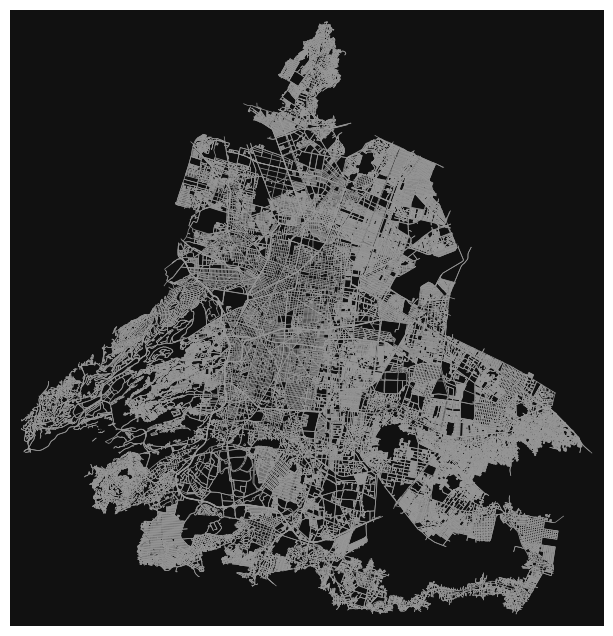

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [31]:
# Plot rápido para verificar que sí es CDMX
ox.plot_graph(G_cdmx, node_size=0, edge_linewidth=0.5)

In [ ]:
# EXPORTAR GRAFO A GRAPHML (PRESERVANDO DIRECCIONALIDAD)


import os

# Crear carpeta para la red vial
os.makedirs("Red vial", exist_ok=True)

graphml_path = "Red vial/red_vial_cdmx.graphml"

# Guardar el grafo preservando todos los atributos
ox.save_graphml(G_cdmx, filepath=graphml_path)

print(f"Grafo guardado exitosamente en: {graphml_path}")
print()
print("Caracteristicas del grafo exportado:")
print(f"  - Nodos: {len(G_cdmx.nodes):,}")
print(f"  - Aristas: {len(G_cdmx.edges):,}")
print(f"  - Dirigido: {G_cdmx.is_directed()}")
print(f"  - Formato: GraphML")
print()
print("[IMPORTANTE] El grafo exportado preserva:")
print("  * Direccionalidad de calles (oneway)")
print("  * Sentidos viales reales")
print("  * Geometria de aristas")
print("  * Atributos OSM completos")

Grafo guardado exitosamente en: Red vial/red_vial_cdmx.graphml

Caracteristicas del grafo exportado:
  - Nodos: 99,712
  - Aristas: 234,484
  - Dirigido: True
  - Formato: GraphML

[IMPORTANTE] El grafo exportado preserva:
  * Direccionalidad de calles (oneway)
  * Sentidos viales reales
  * Geometria de aristas
  * Atributos OSM completos


In [33]:
# Para volver a cargar desde el archivo: 
graphml_path = "Red vial/red_vial_cdmx.graphml"

G_cdmx2 = ox.load_graphml(graphml_path)

print("Nodos:", len(G_cdmx2.nodes), "Aristas:", len(G_cdmx2.edges))

Nodos: 99712 Aristas: 234484


Nodos en la ruta: 102
Longitud total (km): 11.829277807123406
Tiempo total (min): 10.068508024432763


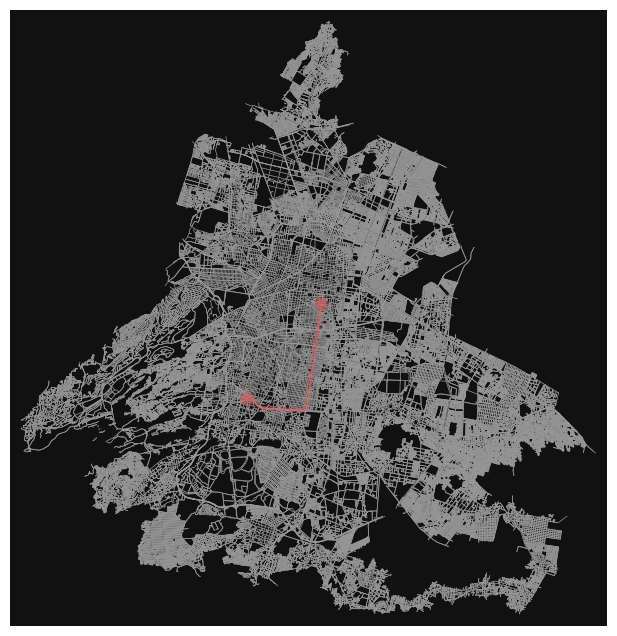

In [34]:
# Usamos el grafo cargado desde el GraphML
G = G_cdmx2  

# Proyectar a metros (para que 'length' esté en m)
G_proj = ox.project_graph(G)

# Función para obtener tiempo de viaje por arista (segundos)
def edge_travel_time(data, default_speed_kmh=40):
    length_m = data.get("length", 0)
    maxspeed = data.get("maxspeed", default_speed_kmh)

    # maxspeed puede venir como lista, string "40", "40;60", "40 km/h", etc.
    if isinstance(maxspeed, (list, tuple)):
        maxspeed = maxspeed[0]
    try:
        speed_kmh = float(str(maxspeed).split(";")[0].split()[0])
    except Exception:
        speed_kmh = default_speed_kmh

    speed_ms = speed_kmh / 3.6
    return length_m / speed_ms if speed_ms > 0 else None

# Añadir atributo tiempo_seg a cada arista
for u, v, k, data in G_proj.edges(keys=True, data=True):
    data["tiempo_seg"] = edge_travel_time(data)

# Elegimos dos nodos de ejemplo (solo demo)
orig = list(G_proj.nodes)[0]
dest = list(G_proj.nodes)[1000]

# Ruta mínima en tiempo
ruta = nx.shortest_path(G_proj, orig, dest, weight="tiempo_seg")

# Calcular longitud y tiempo de la ruta "a mano"
long_total = 0.0
tiempo_total = 0.0
for u, v in zip(ruta[:-1], ruta[1:]):
    # Tomamos una de las aristas entre u y v (MultiDiGraph)
    data = list(G_proj[u][v].values())[0]
    long_total += data.get("length", 0.0)
    tiempo_total += data.get("tiempo_seg", 0.0)

print("Nodos en la ruta:", len(ruta))
print("Longitud total (km):", long_total / 1000)
print("Tiempo total (min):", tiempo_total / 60)

# Dibujar la ruta sobre la red
fig, ax = ox.plot_graph_route(
    G_proj,
    ruta,
    node_size=0,
    edge_linewidth=0.5,
    route_linewidth=3,
)


## Puntos negros en cuadrículas/celdas

In [35]:
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely.geometry import box


In [36]:
# Para volver a cargar desde el archivo: 
graphml_path = "Red vial/red_vial_cdmx.graphml"

G_cdmx2 = ox.load_graphml(graphml_path)

print("Nodos:", len(G_cdmx2.nodes), "Aristas:", len(G_cdmx2.edges))

Nodos: 99712 Aristas: 234484


In [37]:
df_2019_2023 = pd.read_csv("Datos combinados CDMX/ACCIDENTES_COMBINADO_CDMX_2019_2023.csv", parse_dates=["fechahora"], low_memory=False)  # combinado 2019–2023
df_2022_2023 = pd.read_csv("Datos combinados CDMX/ACCIDENTES_COMBINADO_CDMX_2022_2023.csv", parse_dates=["fechahora"], low_memory=False)  # combinado 2022–2023


In [38]:
# Mostrar la forma (rows, columns) de los dataframes relevantes
print("df_2019_2023.shape:", df_2019_2023.shape)
print("df_2022_2023.shape:", df_2022_2023.shape)

df_2019_2023.shape: (32139, 56)
df_2022_2023.shape: (11047, 56)


In [39]:
# lista de columnas
print("Columnas en df_2019_2023:")
print(list(df_2019_2023.columns))

Columnas en df_2019_2023:
['id', 'edo', 'mes', 'anio', 'mpio', 'hora', 'minutos', 'dia', 'diasemana', 'urbana', 'suburbana', 'tipaccid', 'automovil', 'campasaj', 'microbus', 'pascamion', 'omnibus', 'tranvia', 'camioneta', 'camion', 'tractor', 'ferrocarri', 'motociclet', 'bicicleta', 'otrovehic', 'causaacci', 'caparod', 'sexo', 'aliento', 'cinturon', 'edad', 'condmuerto', 'condherido', 'pasamuerto', 'pasaherido', 'peatmuerto', 'peatherido', 'ciclmuerto', 'ciclherido', 'otromuerto', 'otroherido', 'totmuertos', 'totheridos', 'clase', 'calle1', 'calle2', 'carretera', 'longitud', 'latitud', 'fechahora', 'severidad', 'hay_muertos', 'hay_heridos', 'solo_daños_materiales', 'severidad_cat', 'franja_horaria']


In [40]:
def cuadricula_y_stats(df, cell_size_m=400, umbral_severidad=10):
    # puntos -> GeoDataFrame (WGS84)
    gdf = gpd.GeoDataFrame(
        df.copy(),
        geometry=gpd.points_from_xy(df["longitud"], df["latitud"]),
        crs="EPSG:4326")
    
    # proyectamos a metros
    gdf = gdf.to_crs(epsg=3857)

    # crear celdas regulares
    minx, miny, maxx, maxy = gdf.total_bounds
    xs = np.arange(minx, maxx + cell_size_m, cell_size_m)
    ys = np.arange(miny, maxy + cell_size_m, cell_size_m)

    celdas = [box(x, y, x + cell_size_m, y + cell_size_m)
              for x in xs[:-1] for y in ys[:-1]]

    grid = gpd.GeoDataFrame(
        {"cell_id": range(len(celdas))},
        geometry=celdas,
        crs=gdf.crs)

    # asignar accidentes a celdas
    puntos_en_celdas = gpd.sjoin(gdf, grid, how="left", predicate="within")

    # marcar accidentes graves
    puntos_en_celdas["es_grave"] = (
        (puntos_en_celdas["totmuertos"] > 0) |
        (puntos_en_celdas["severidad"] >= umbral_severidad))

    # agregados por celda
    stats = puntos_en_celdas.groupby("cell_id").agg(
        accidentes_totales=("id", "size"),
        accidentes_graves=("es_grave", "sum"),
        severidad_total=("severidad", "sum"),).reset_index()

    grid_stats = grid.merge(stats, on="cell_id", how="left").fillna(0)

    print("Celdas:", len(grid_stats), "| accidentes:", len(puntos_en_celdas))
    return puntos_en_celdas, grid_stats

# Uso
acc_celdas_2019_2023, grid_2019_2023 = cuadricula_y_stats(df_2019_2023, cell_size_m=200, umbral_severidad=10)
acc_celdas_2022_2023, grid_2022_2023 = cuadricula_y_stats(df_2022_2023, cell_size_m=200, umbral_severidad=10)

Celdas: 62062 | accidentes: 32139
Celdas: 54704 | accidentes: 11047


In [41]:
# Stats básicas de las celdas (2019–2023)
print(grid_2019_2023[["accidentes_totales","accidentes_graves","severidad_total"]].describe())
print(grid_2022_2023[["accidentes_totales","accidentes_graves","severidad_total"]].describe())


       accidentes_totales  accidentes_graves  severidad_total
count        62062.000000       62062.000000     62062.000000
mean             0.517821           0.012729         0.504012
std              2.178851           0.131914         2.906692
min              0.000000           0.000000         0.000000
25%              0.000000           0.000000         0.000000
50%              0.000000           0.000000         0.000000
75%              0.000000           0.000000         0.000000
max             53.000000           8.000000       158.000000
       accidentes_totales  accidentes_graves  severidad_total
count        54704.000000       54704.000000     54704.000000
mean             0.201905           0.006106         0.221337
std              0.904069           0.085934         1.655360
min              0.000000           0.000000         0.000000
25%              0.000000           0.000000         0.000000
50%              0.000000           0.000000         0.000000
75%     

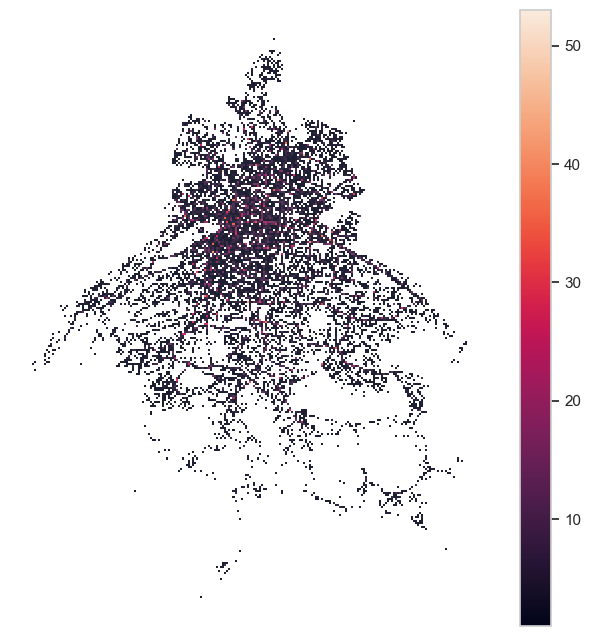

In [42]:
# Heatmap de accidentes totales (2019–2023)
ax = grid_2019_2023.query("accidentes_totales>0").plot(column="accidentes_totales", figsize=(8,8), legend=True, alpha=0.9, edgecolor="none"); ax.set_axis_off()


## Índice de riesgo compuesto

Calcularemos un índice de riesgo normalizado que combina:
- N: número total de accidentes
- S: severidad total
- F: número de accidentes fatales

Fórmula: riesgo = 0.4 * N_norm + 0.4 * S_norm + 0.2 * F_norm

In [43]:
def calcular_indice_riesgo(grid_stats, w_n=0.4, w_s=0.4, w_f=0.2):
    """
    Calcula índice de riesgo normalizado por celda
    riesgo = w_n*N_norm + w_s*S_norm + w_f*F_norm
    """
    grid = grid_stats.copy()
    
    # Normalización min-max
    def minmax_norm(serie):
        vmin, vmax = serie.min(), serie.max()
        if vmax == vmin:
            return serie * 0
        return (serie - vmin) / (vmax - vmin)
    
    grid['N_norm'] = minmax_norm(grid['accidentes_totales'])
    grid['S_norm'] = minmax_norm(grid['severidad_total'])
    grid['F_norm'] = minmax_norm(grid['accidentes_graves'])
    
    grid['indice_riesgo'] = w_n * grid['N_norm'] + w_s * grid['S_norm'] + w_f * grid['F_norm']
    
    return grid

# Calcular índice para ambos periodos
grid_2019_2023 = calcular_indice_riesgo(grid_2019_2023)
grid_2022_2023 = calcular_indice_riesgo(grid_2022_2023)

print("Estadísticas de índice de riesgo (2019-2023):")
print(grid_2019_2023['indice_riesgo'].describe())

Estadísticas de índice de riesgo (2019-2023):
count    62062.000000
mean         0.005502
std          0.024254
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.939623
Name: indice_riesgo, dtype: float64


## Dimensión temporal del riesgo

Calcularemos índices de riesgo específicos por franja horaria y día de semana.

In [44]:
def calcular_riesgo_por_franja(acc_celdas, grid_base, cell_size_m=200):
    """
    Calcula índice de riesgo por celda para cada franja horaria
    Retorna diccionario {franja: grid_con_riesgo}
    """
    franjas = ['Madrugada', 'Mañana', 'Tarde', 'Noche']
    resultados = {}
    
    for franja in franjas:
        # Filtrar accidentes de esta franja
        acc_franja = acc_celdas[acc_celdas['franja_horaria'] == franja].copy()
        
        if len(acc_franja) == 0:
            continue
        
        # Marcar graves
        acc_franja['es_grave'] = (
            (acc_franja['totmuertos'] > 0) | 
            (acc_franja['severidad'] >= 10))
        
        # Agregar por celda
        stats = acc_franja.groupby('cell_id').agg(
            accidentes_totales=('id', 'size'),
            accidentes_graves=('es_grave', 'sum'),
            severidad_total=('severidad', 'sum')).reset_index()
        
        # Unir con grid base
        grid_franja = grid_base[['cell_id', 'geometry']].merge(
            stats, on='cell_id', how='left').fillna(0)
        
        # Calcular índice de riesgo
        grid_franja = calcular_indice_riesgo(grid_franja)
        
        resultados[franja] = grid_franja
        print(f"{franja}: {len(acc_franja)} accidentes, "
              f"{(grid_franja['indice_riesgo']>0).sum()} celdas con riesgo")
    
    return resultados

# Calcular para 2019-2023
print("Calculando riesgo por franja horaria (2019-2023):")
riesgo_por_franja_2019_2023 = calcular_riesgo_por_franja(
    acc_celdas_2019_2023, grid_2019_2023)

Calculando riesgo por franja horaria (2019-2023):
Madrugada: 5092 accidentes, 3083 celdas con riesgo
Mañana: 9179 accidentes, 4581 celdas con riesgo
Tarde: 9590 accidentes, 4914 celdas con riesgo
Noche: 8278 accidentes, 4471 celdas con riesgo


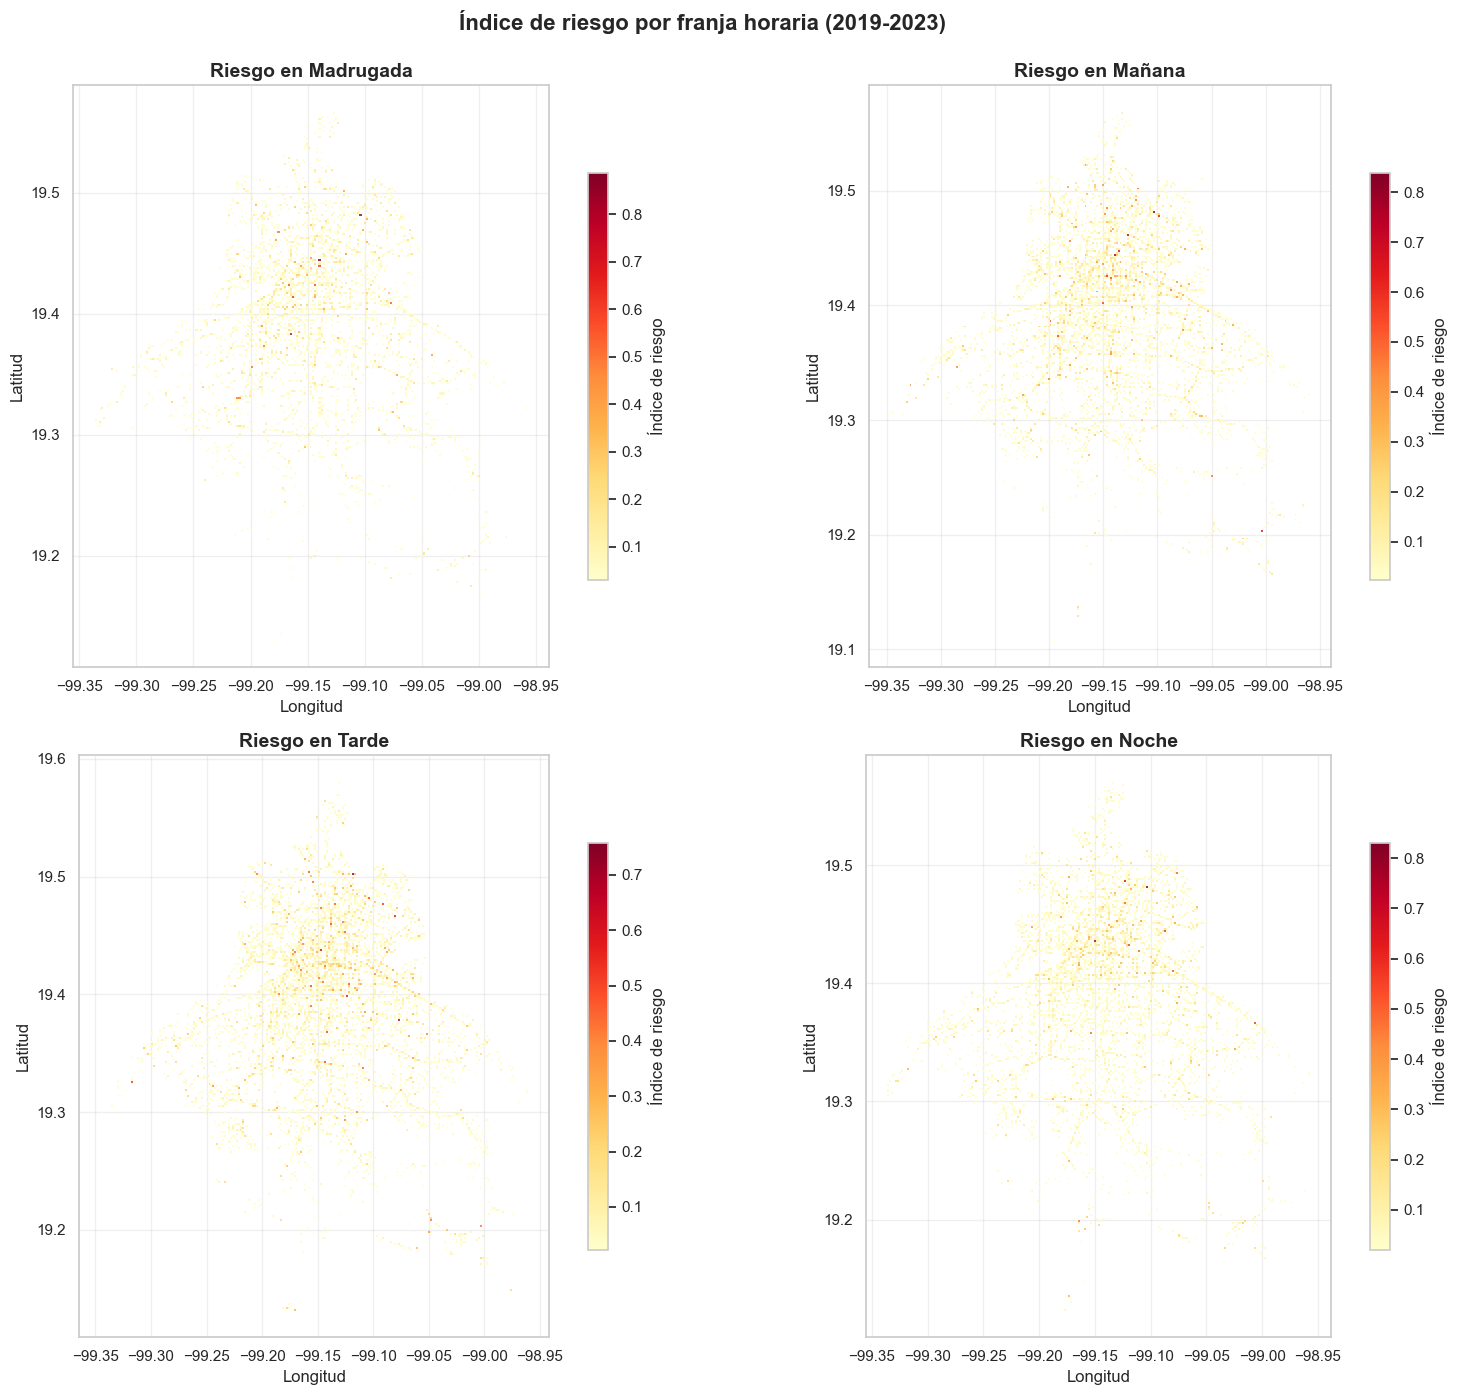

In [45]:
def plot_mapas_riesgo_por_franja(riesgo_dict, figsize=(10, 8), cmap='YlOrRd'):
    """
    Genera mapas de riesgo para cada franja horaria con estilo unificado
    """
    franjas_orden = ['Madrugada', 'Mañana', 'Tarde', 'Noche']
    n_franjas = len([f for f in franjas_orden if f in riesgo_dict])
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.flatten()
    
    for idx, franja in enumerate(franjas_orden):
        if franja not in riesgo_dict:
            axes[idx].axis('off')
            continue
        
        grid_f = riesgo_dict[franja]
        grid_con_riesgo = grid_f[grid_f['indice_riesgo'] > 0]
        
        ax = axes[idx]
        
        # Proyectar a lat/lon para visualización
        grid_plot = grid_con_riesgo.to_crs(epsg=4326)
        
        grid_plot.plot(
            column='indice_riesgo',
            ax=ax,
            cmap=cmap,
            legend=True,
            alpha=0.8,
            edgecolor='none',
            legend_kwds={'label': 'Índice de riesgo', 'shrink': 0.7})
        
        ax.set_title(f'Riesgo en {franja}', fontsize=14, weight='bold')
        ax.set_xlabel('Longitud')
        ax.set_ylabel('Latitud')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Índice de riesgo por franja horaria (2019-2023)', 
                 fontsize=16, weight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

plot_mapas_riesgo_por_franja(riesgo_por_franja_2019_2023)

## Ponderación por año

Aplicaremos mayor peso a años recientes para reflejar mejor el estado actual de la red vial.
Esquema: 2019→0.10, 2020→0.15, 2021→0.20, 2022→0.25, 2023→0.30

In [46]:
def calcular_riesgo_ponderado_por_anio(acc_celdas, grid_base):
    """
    Calcula índice de riesgo con ponderación creciente por año
    Mayor peso a años más recientes
    """
    # Pesos por año (suman 1.0)
    pesos = {2019: 0.10, 2020: 0.15, 2021: 0.20, 2022: 0.25, 2023: 0.30}
    
    grid_pond = grid_base[['cell_id', 'geometry']].copy()
    grid_pond['severidad_ponderada'] = 0.0
    grid_pond['accidentes_ponderados'] = 0.0
    grid_pond['graves_ponderados'] = 0.0
    
    for anio, peso in pesos.items():
        # Filtrar accidentes del año
        acc_anio = acc_celdas[acc_celdas['anio'] == anio].copy()
        
        if len(acc_anio) == 0:
            continue
        
        acc_anio['es_grave'] = (
            (acc_anio['totmuertos'] > 0) | 
            (acc_anio['severidad'] >= 10))
        
        # Agregar por celda
        stats_anio = acc_anio.groupby('cell_id').agg(
            acc_count=('id', 'size'),
            sev_sum=('severidad', 'sum'),
            graves_count=('es_grave', 'sum')).reset_index()
        
        # Aplicar ponderación
        stats_anio['acc_pond'] = stats_anio['acc_count'] * peso
        stats_anio['sev_pond'] = stats_anio['sev_sum'] * peso
        stats_anio['graves_pond'] = stats_anio['graves_count'] * peso
        
        # Acumular en grid
        for _, row in stats_anio.iterrows():
            idx = grid_pond[grid_pond['cell_id'] == row['cell_id']].index
            if len(idx) > 0:
                grid_pond.loc[idx[0], 'accidentes_ponderados'] += row['acc_pond']
                grid_pond.loc[idx[0], 'severidad_ponderada'] += row['sev_pond']
                grid_pond.loc[idx[0], 'graves_ponderados'] += row['graves_pond']
        
        print(f"Año {anio}: {len(acc_anio)} accidentes, peso={peso}")
    
    # Renombrar para usar función existente de cálculo de índice
    grid_pond['accidentes_totales'] = grid_pond['accidentes_ponderados']
    grid_pond['severidad_total'] = grid_pond['severidad_ponderada']
    grid_pond['accidentes_graves'] = grid_pond['graves_ponderados']
    
    # Calcular índice de riesgo
    grid_pond = calcular_indice_riesgo(grid_pond)
    
    return grid_pond

print("Calculando riesgo ponderado por año (2019-2023):")
grid_ponderado_2019_2023 = calcular_riesgo_ponderado_por_anio(
    acc_celdas_2019_2023, grid_2019_2023)

print(f"\nCeldas con riesgo ponderado > 0: "
      f"{(grid_ponderado_2019_2023['indice_riesgo']>0).sum()}")

Calculando riesgo ponderado por año (2019-2023):
Año 2019: 9948 accidentes, peso=0.1
Año 2020: 5836 accidentes, peso=0.15
Año 2021: 5308 accidentes, peso=0.2
Año 2022: 5141 accidentes, peso=0.25
Año 2023: 5906 accidentes, peso=0.3

Celdas con riesgo ponderado > 0: 8740


## Preparación para trabajar con tramos de calle

Asignaremos cada accidente al tramo de calle (edge) más cercano del grafo vial.

In [47]:
import pandas as pd
import numpy as np
import geopandas as gpd
import osmnx as ox
import os

# Cargar datos de accidentes CDMX
df_cdmx_2019_2023 = pd.read_csv("Datos combinados CDMX/ACCIDENTES_COMBINADO_CDMX_2019_2023.csv",
                                 parse_dates=["fechahora"], low_memory=False)

# Cargar grafo vial
graphml_path = "Red vial/red_vial_cdmx.graphml"
G_cdmx2 = ox.load_graphml(graphml_path)

print(f"Datos cargados:")
print(f"- Accidentes CDMX 2019-2023: {df_cdmx_2019_2023.shape}")
print(f"- Grafo vial - Nodos: {len(G_cdmx2.nodes)}, Aristas: {len(G_cdmx2.edges)}")


Datos cargados:
- Accidentes CDMX 2019-2023: (32139, 56)
- Grafo vial - Nodos: 99712, Aristas: 234484


In [48]:
def asignar_accidentes_a_tramos(df_accidentes, grafo):
    """
    Asigna cada accidente al tramo de calle (edge) más cercano del grafo vial.

    Parámetros:
    -----------
    df_accidentes : DataFrame o GeoDataFrame
        DataFrame con accidentes que debe tener columnas 'longitud' y 'latitud'
    grafo : networkx.MultiDiGraph
        Grafo vial de OSMnx

    Retorna:
    --------
    GeoDataFrame con columnas adicionales:
        - edge_u: nodo origen del tramo
        - edge_v: nodo destino del tramo
        - edge_key: clave del edge (para MultiDiGraph)
        - distancia_edge: distancia en metros del punto al tramo
    """
    print(f"Asignando {len(df_accidentes)} accidentes a tramos...")

    # Convertir a GeoDataFrame si no lo es
    if not isinstance(df_accidentes, gpd.GeoDataFrame):
        gdf = gpd.GeoDataFrame(
            df_accidentes,
            geometry=gpd.points_from_xy(df_accidentes['longitud'],
                                       df_accidentes['latitud']),
            crs='EPSG:4326')
    else:
        gdf = df_accidentes.copy()

    # Proyectar grafo y obtener edges como GeoDataFrame
    G_proj = ox.project_graph(grafo)
    edges_gdf = ox.graph_to_gdfs(G_proj, nodes=False, edges=True)

    print(f"Grafo: {len(edges_gdf)} tramos en CRS {edges_gdf.crs}")

    # CRÍTICO: Proyectar puntos al MISMO CRS que los edges
    gdf_proj = gdf.to_crs(edges_gdf.crs)

    # Encontrar edge más cercano para cada punto
    edges_asignados = []
    distancias = []

    total = len(gdf_proj)
    for idx in range(total):
        punto = gdf_proj.iloc[idx].geometry

        # Calcular distancia a todos los edges
        dists = edges_gdf.geometry.distance(punto)
        min_idx = dists.idxmin()

        edges_asignados.append(min_idx)
        distancias.append(dists[min_idx])

        # Mostrar progreso cada 1000 registros
        if (idx + 1) % 1000 == 0 or (idx + 1) == total:
            print(f"  Progreso: {idx+1}/{total} ({100*(idx+1)/total:.1f}%)")

    # Agregar resultados al dataframe original
    gdf['edge_u'] = [e[0] for e in edges_asignados]
    gdf['edge_v'] = [e[1] for e in edges_asignados]
    gdf['edge_key'] = [e[2] for e in edges_asignados]
    gdf['distancia_edge'] = distancias

    # Estadísticas finales
    tramos_unicos = gdf[['edge_u','edge_v','edge_key']].drop_duplicates().shape[0]
    dist_prom = np.mean(distancias)
    dist_max = np.max(distancias)

    print(f"\nRESULTADO:")
    print(f"  - Accidentes procesados: {len(gdf)}")
    print(f"  - Tramos únicos asignados: {tramos_unicos}")
    print(f"  - Distancia promedio al tramo: {dist_prom:.2f} m")
    print(f"  - Distancia máxima al tramo: {dist_max:.2f} m")

    return gdf

In [49]:
def calcular_stats_por_tramo(df_con_tramos):
    """
    Calcula estadísticas de accidentes por tramo de calle
    """
    stats_tramos = df_con_tramos.groupby(['edge_u', 'edge_v', 'edge_key']).agg(
        accidentes_totales=('id', 'size'),
        severidad_total=('severidad', 'sum'),
        muertos_totales=('totmuertos', 'sum'),
        heridos_totales=('totheridos', 'sum'),
        accidentes_graves=('hay_muertos', 'sum'),
        distancia_prom_edge=('distancia_edge', 'mean')).reset_index()

    print(f"\nEstadísticas calculadas para {len(stats_tramos)} tramos")
    print(f"\nTop 10 tramos más peligrosos por severidad:")
    top10 = stats_tramos.nlargest(10, 'severidad_total')[
        ['edge_u', 'edge_v', 'accidentes_totales', 'muertos_totales',
         'heridos_totales', 'severidad_total']]
    display(top10)

    return stats_tramos

In [50]:
# Asignar TODOS los accidentes de CDMX 2019-2023 a tramos
print(" ASIGNANDO TODOS LOS ACCIDENTES CDMX 2019-2023 A TRAMOS \n")
df_cdmx_con_tramos = asignar_accidentes_a_tramos(df_cdmx_2019_2023, G_cdmx2)

# Calcular estadísticas por tramo
print("\n" + "="*60)
stats_tramos_cdmx = calcular_stats_por_tramo(df_cdmx_con_tramos)

# Guardar resultados
print("\nGuardando resultados...")
df_cdmx_con_tramos.to_csv("Datos combinados CDMX/ACCIDENTES_CON_TRAMOS_2019_2023.csv", index=False)
stats_tramos_cdmx.to_csv("Datos combinados CDMX/STATS_POR_TRAMO_2019_2023.csv", index=False)
print("Archivos guardados en 'Datos combinados CDMX/'")

 ASIGNANDO TODOS LOS ACCIDENTES CDMX 2019-2023 A TRAMOS 

Asignando 32139 accidentes a tramos...
Grafo: 234484 tramos en CRS EPSG:32614
  Progreso: 1000/32139 (3.1%)
  Progreso: 2000/32139 (6.2%)
  Progreso: 3000/32139 (9.3%)
  Progreso: 4000/32139 (12.4%)
  Progreso: 5000/32139 (15.6%)
  Progreso: 6000/32139 (18.7%)
  Progreso: 7000/32139 (21.8%)
  Progreso: 8000/32139 (24.9%)
  Progreso: 9000/32139 (28.0%)
  Progreso: 10000/32139 (31.1%)
  Progreso: 11000/32139 (34.2%)
  Progreso: 12000/32139 (37.3%)
  Progreso: 13000/32139 (40.4%)
  Progreso: 14000/32139 (43.6%)
  Progreso: 15000/32139 (46.7%)
  Progreso: 16000/32139 (49.8%)
  Progreso: 17000/32139 (52.9%)
  Progreso: 18000/32139 (56.0%)
  Progreso: 19000/32139 (59.1%)
  Progreso: 20000/32139 (62.2%)
  Progreso: 21000/32139 (65.3%)
  Progreso: 22000/32139 (68.5%)
  Progreso: 23000/32139 (71.6%)
  Progreso: 24000/32139 (74.7%)
  Progreso: 25000/32139 (77.8%)
  Progreso: 26000/32139 (80.9%)
  Progreso: 27000/32139 (84.0%)
  Progreso: 

,edge_u,edge_v,accidentes_totales,muertos_totales,heridos_totales,severidad_total
11966,3542122525,3542541044,192,15,125,525
14916,12285957948,272197209,69,14,52,296
10907,2261185190,8533600845,91,9,44,222
11950,3509041853,3509041873,48,8,42,206
7081,389002223,6124106821,37,6,24,132
8427,670093982,3383521371,65,5,17,101
12460,4735188322,2266648195,28,5,10,80
1180,268903372,1966419083,54,1,23,79
199,30533863,8293182168,54,4,10,70
14459,8337217165,297350576,40,0,22,66



Guardando resultados...
Archivos guardados en 'Datos combinados CDMX/'


In [51]:
# Verificar resultados
print(" VERIFICACIÓN DE RESULTADOS \n")

print("Primeros 10 accidentes con sus tramos asignados:")
display(df_cdmx_con_tramos[['id', 'longitud', 'latitud', 'edge_u', 'edge_v',
                             'edge_key', 'distancia_edge', 'severidad']].head(10))

print("\nDistribución de distancias al tramo más cercano:")
print(df_cdmx_con_tramos['distancia_edge'].describe())

print("\nTop 20 tramos más peligrosos:")
display(stats_tramos_cdmx.nlargest(20, 'severidad_total'))

 VERIFICACIÓN DE RESULTADOS 

Primeros 10 accidentes con sus tramos asignados:


,id,longitud,latitud,edge_u,edge_v,edge_key,distancia_edge,severidad
0,408,-99.20335,19.48374,269343999,372453602,0,0.270123,6
1,409,-99.20493,19.51350,8167712493,1932429931,0,0.213782,0
2,410,-99.17616,19.46819,7982345896,7982345894,0,4.345150,0
3,411,-99.17347,19.49070,2733145454,2732924575,0,0.436629,3
4,412,-99.14524,19.46432,270462193,12912266093,0,10.463285,0
5,413,-99.14833,19.46344,8751101089,1409192254,0,5.634409,0
6,414,-99.15085,19.46808,370465452,386248413,0,0.333013,3
7,415,-99.18479,19.49678,366177498,6133532381,0,0.611449,3
8,416,-99.17703,19.48438,387152343,387152423,0,3.646381,0
9,417,-99.15184,19.48889,60916381,1404054457,0,1.144500,3



Distribución de distancias al tramo más cercano:
count    32139.000000
mean       102.585272
std        763.237915
min          0.000194
25%          0.886077
50%          2.064649
75%          4.147582
max      18211.918360
Name: distancia_edge, dtype: float64

Top 20 tramos más peligrosos:


,edge_u,edge_v,edge_key,accidentes_totales,severidad_total,muertos_totales,heridos_totales,accidentes_graves,distancia_prom_edge
11966,3542122525,3542541044,0,192,525,15,125,15,5522.966293
14916,12285957948,272197209,0,69,296,14,52,12,1967.430339
10907,2261185190,8533600845,0,91,222,9,44,8,7506.615760
11950,3509041853,3509041873,0,48,206,8,42,7,4125.747484
7081,389002223,6124106821,0,37,132,6,24,6,1.688822
8427,670093982,3383521371,0,65,101,5,17,5,2225.922161
12460,4735188322,2266648195,0,28,80,5,10,5,1.166981
1180,268903372,1966419083,0,54,79,1,23,1,2.344375
199,30533863,8293182168,0,54,70,4,10,4,2727.697572
14459,8337217165,297350576,0,40,66,0,22,0,2.987717


## Análisis detallado de tramos peligrosos

Análisis específico de los segmentos de calle más peligrosos identificados.

In [52]:
# Top 30 tramos por severidad
top_tramos = stats_tramos_cdmx.nlargest(30, 'severidad_total')

print(f"Total de tramos con accidentes: {len(stats_tramos_cdmx)}")
print(f"Tramos con al menos 1 muerto: {(stats_tramos_cdmx['muertos_totales'] > 0).sum()}")
print(f"Tramos con 5+ accidentes: {(stats_tramos_cdmx['accidentes_totales'] >= 5).sum()}\n")

print("Top 30 tramos más peligrosos por severidad:")
display(top_tramos[['edge_u', 'edge_v', 'accidentes_totales', 'muertos_totales',
                    'heridos_totales', 'severidad_total', 'distancia_prom_edge']])

Total de tramos con accidentes: 14982
Tramos con al menos 1 muerto: 623
Tramos con 5+ accidentes: 1301

Top 30 tramos más peligrosos por severidad:


,edge_u,edge_v,accidentes_totales,muertos_totales,heridos_totales,severidad_total,distancia_prom_edge
11966,3542122525,3542541044,192,15,125,525,5522.966293
14916,12285957948,272197209,69,14,52,296,1967.430339
10907,2261185190,8533600845,91,9,44,222,7506.615760
11950,3509041853,3509041873,48,8,42,206,4125.747484
7081,389002223,6124106821,37,6,24,132,1.688822
8427,670093982,3383521371,65,5,17,101,2225.922161
12460,4735188322,2266648195,28,5,10,80,1.166981
1180,268903372,1966419083,54,1,23,79,2.344375
199,30533863,8293182168,54,4,10,70,2727.697572
14459,8337217165,297350576,40,0,22,66,2.987717


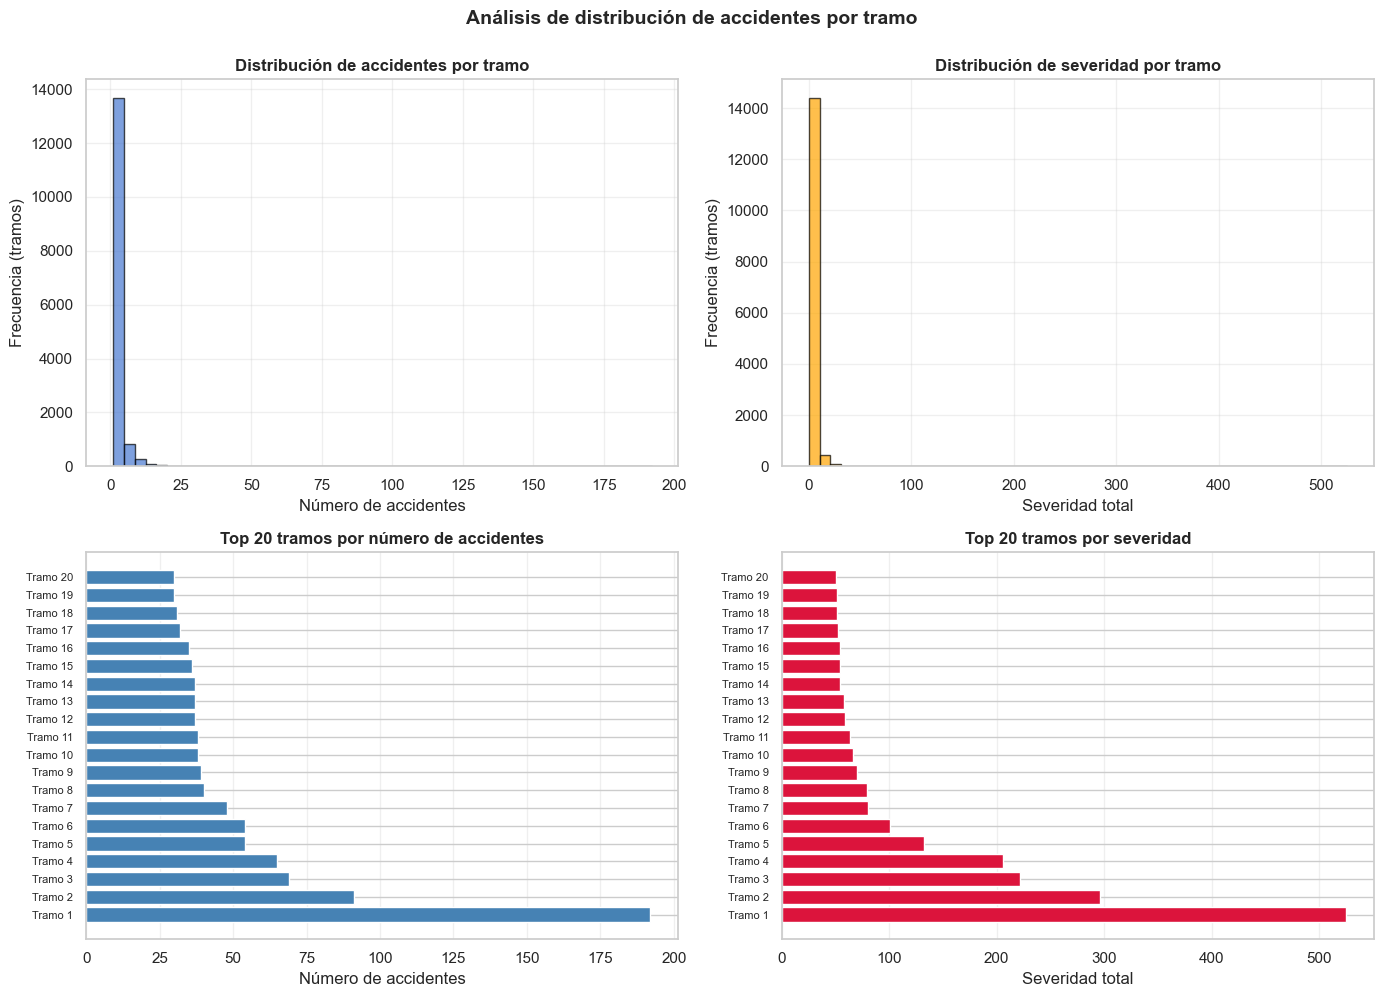

In [53]:
# Distribución de accidentes por tramo
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histograma de accidentes por tramo
ax = axes[0, 0]
stats_tramos_cdmx['accidentes_totales'].hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
ax.set_title('Distribución de accidentes por tramo', fontsize=12, weight='bold')
ax.set_xlabel('Número de accidentes')
ax.set_ylabel('Frecuencia (tramos)')
ax.grid(True, alpha=0.3)

# Histograma de severidad por tramo
ax = axes[0, 1]
stats_tramos_cdmx['severidad_total'].hist(bins=50, ax=ax, edgecolor='black', alpha=0.7, color='orange')
ax.set_title('Distribución de severidad por tramo', fontsize=12, weight='bold')
ax.set_xlabel('Severidad total')
ax.set_ylabel('Frecuencia (tramos)')
ax.grid(True, alpha=0.3)

# Top 20 tramos por accidentes
ax = axes[1, 0]
top20_acc = stats_tramos_cdmx.nlargest(20, 'accidentes_totales')
y_pos = np.arange(len(top20_acc))
ax.barh(y_pos, top20_acc['accidentes_totales'].values, color='steelblue')
ax.set_yticks(y_pos)
ax.set_yticklabels([f"Tramo {i+1}" for i in range(len(top20_acc))], fontsize=8)
ax.set_xlabel('Número de accidentes')
ax.set_title('Top 20 tramos por número de accidentes', fontsize=12, weight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Top 20 tramos por severidad
ax = axes[1, 1]
top20_sev = stats_tramos_cdmx.nlargest(20, 'severidad_total')
y_pos = np.arange(len(top20_sev))
ax.barh(y_pos, top20_sev['severidad_total'].values, color='crimson')
ax.set_yticks(y_pos)
ax.set_yticklabels([f"Tramo {i+1}" for i in range(len(top20_sev))], fontsize=8)
ax.set_xlabel('Severidad total')
ax.set_title('Top 20 tramos por severidad', fontsize=12, weight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.suptitle('Análisis de distribución de accidentes por tramo', fontsize=14, weight='bold', y=0.995)
plt.tight_layout()
plt.show()

Generando mapa de tramos más peligrosos...



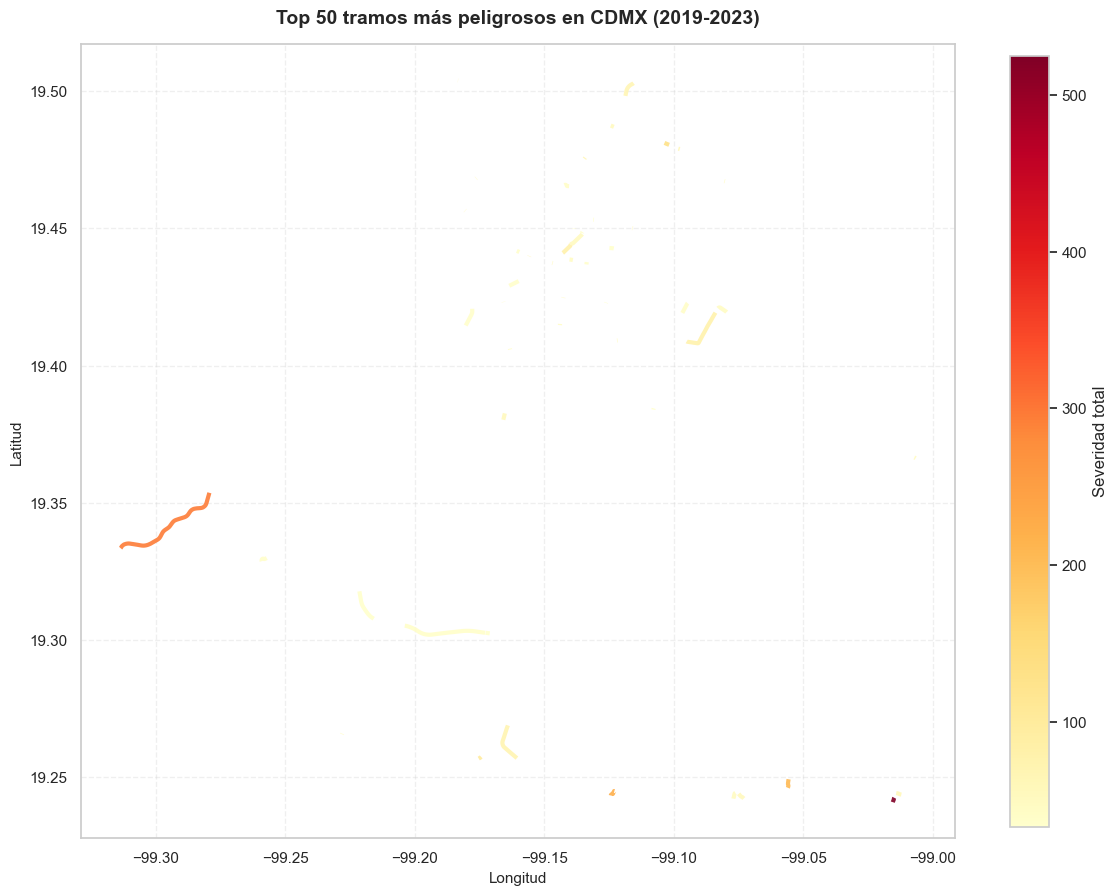


Se visualizaron los 50 tramos más peligrosos
Severidad total en estos tramos: 3465
Esto representa el 11.1% de la severidad total


In [54]:
# Mapa de tramos más peligrosos
print("Generando mapa de tramos más peligrosos...\n")

# Obtener edges del grafo como GeoDataFrame
G_proj = ox.project_graph(G_cdmx2)
edges_gdf = ox.graph_to_gdfs(G_proj, nodes=False, edges=True)

# Top 50 tramos más peligrosos
top50_tramos = stats_tramos_cdmx.nlargest(50, 'severidad_total')
top50_tramos['edge_tuple'] = list(zip(top50_tramos['edge_u'],
                                       top50_tramos['edge_v'],
                                       top50_tramos['edge_key']))

# Filtrar edges del grafo
tramos_peligrosos = edges_gdf.reset_index()
tramos_peligrosos['edge_tuple'] = list(zip(tramos_peligrosos['u'],
                                            tramos_peligrosos['v'],
                                            tramos_peligrosos['key']))
tramos_peligrosos = tramos_peligrosos[
    tramos_peligrosos['edge_tuple'].isin(top50_tramos['edge_tuple'])]

# Merge con datos de severidad
tramos_peligrosos = tramos_peligrosos.merge(
    top50_tramos[['edge_tuple', 'severidad_total', 'accidentes_totales', 'muertos_totales']],
    on='edge_tuple', how='left')

# Proyectar a lat/lon para visualización
tramos_plot = tramos_peligrosos.to_crs(epsg=4326)

# Mapa
fig, ax = plt.subplots(figsize=(12, 10))

tramos_plot.plot(
    ax=ax,
    column='severidad_total',
    cmap='YlOrRd',
    linewidth=3,
    alpha=0.9,
    legend=True,
    legend_kwds={'label': 'Severidad total', 'orientation': 'vertical', 'shrink': 0.8})

ax.set_title('Top 50 tramos más peligrosos en CDMX (2019-2023)', fontsize=14, weight='bold', pad=15)
ax.set_xlabel('Longitud', fontsize=11)
ax.set_ylabel('Latitud', fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f"\nSe visualizaron los {len(tramos_plot)} tramos más peligrosos")
print(f"Severidad total en estos tramos: {tramos_plot['severidad_total'].sum():.0f}")
print(f"Esto representa el {100*tramos_plot['severidad_total'].sum()/stats_tramos_cdmx['severidad_total'].sum():.1f}% de la severidad total")

## Visualizaciones finales unificadas

Mapas de calor globales y tabla de zonas más peligrosas

In [55]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt


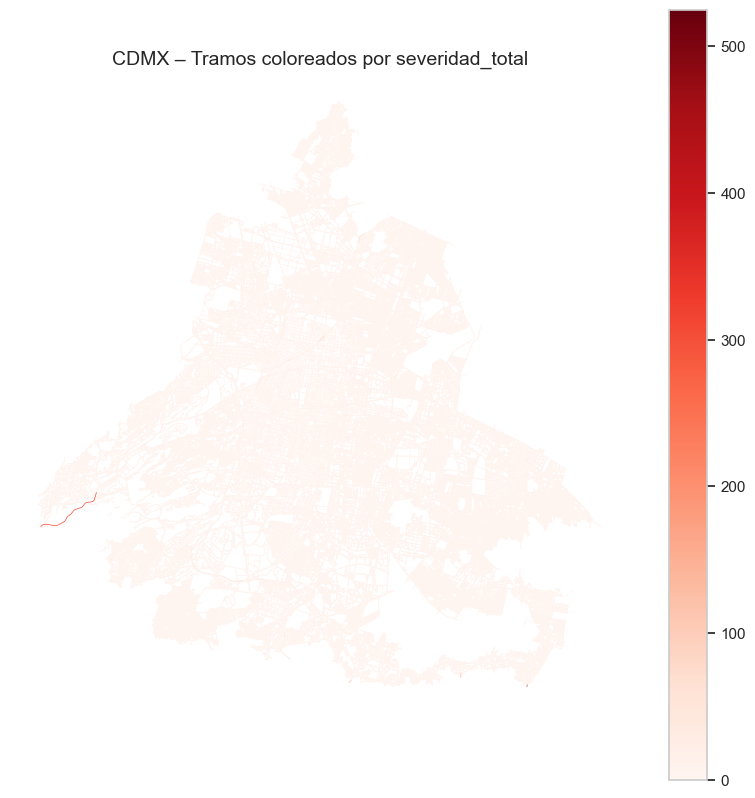

In [56]:
# Sacar los edges del MISMO grafo de asignar accidentes
edges_cdmx = ox.graph_to_gdfs(G_cdmx2, nodes=False, edges=True)

#  Asegurarnos de tener columnas (u, v, key) como columnas normales
edges_cdmx = edges_cdmx.reset_index() 

# Unir las estadísticas al GeoDataFrame de edges
edges_con_stats = edges_cdmx.merge(
    stats_tramos_cdmx,
    left_on=['u', 'v', 'key'],
    right_on=['edge_u', 'edge_v', 'edge_key'],
    how='left'
)

# Rellenar NaN (tramos sin accidentes) con 0
for col in ['accidentes_totales', 'severidad_total',
            'muertos_totales', 'heridos_totales']:
    if col in edges_con_stats.columns:
        edges_con_stats[col] = edges_con_stats[col].fillna(0)

# Proyectar para que el mapa se vea mejor en metros
edges_con_stats = edges_con_stats.to_crs(epsg=3857)

# Calles coloreadas según severidad_total
fig, ax = plt.subplots(figsize=(10, 10))

edges_con_stats.plot(
    ax=ax,
    column='severidad_total',   # puedes cambiar a 'accidentes_totales', etc.
    linewidth=0.5,
    cmap='Reds',
    legend=True
)

ax.set_axis_off()
ax.set_title('CDMX – Tramos coloreados por severidad_total', fontsize=14)
plt.show()


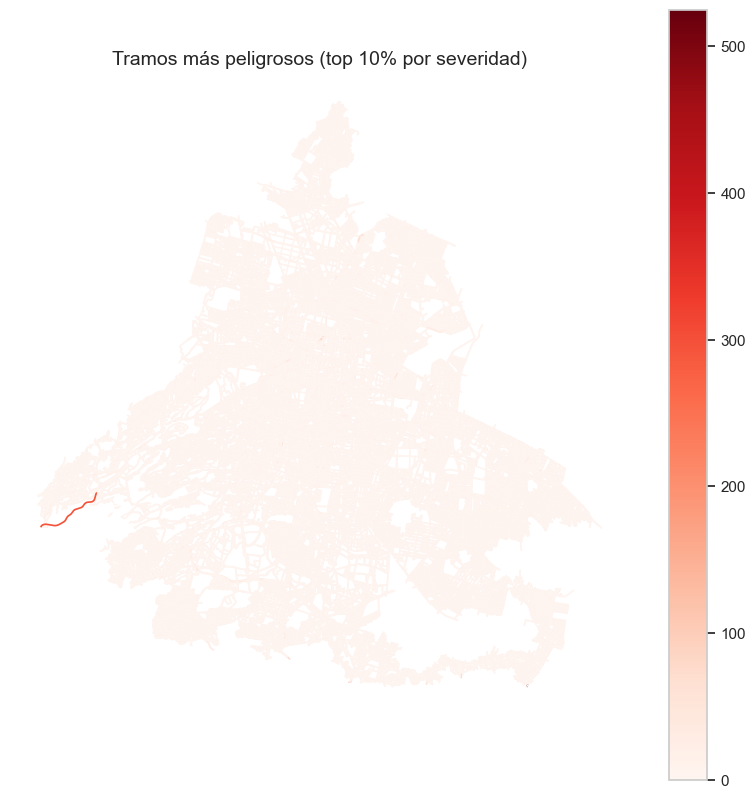

In [57]:
# Top 10% de tramos por severidad_total
umbral = edges_con_stats['severidad_total'].quantile(0.9)
peligrosos = edges_con_stats[edges_con_stats['severidad_total'] >= umbral]

fig, ax = plt.subplots(figsize=(10, 10))

# Primero todas las calles en gris suave
edges_con_stats.plot(ax=ax, linewidth=0.2, color='lightgray')

# Luego los tramos peligrosos encima en rojo
peligrosos.plot(
    ax=ax,
    column='severidad_total',
    linewidth=1.2,
    cmap='Reds',
    legend=True
)

ax.set_axis_off()
ax.set_title('Tramos más peligrosos (top 10% por severidad)', fontsize=14)
plt.show()


Mapa de calor global 2019-2023:


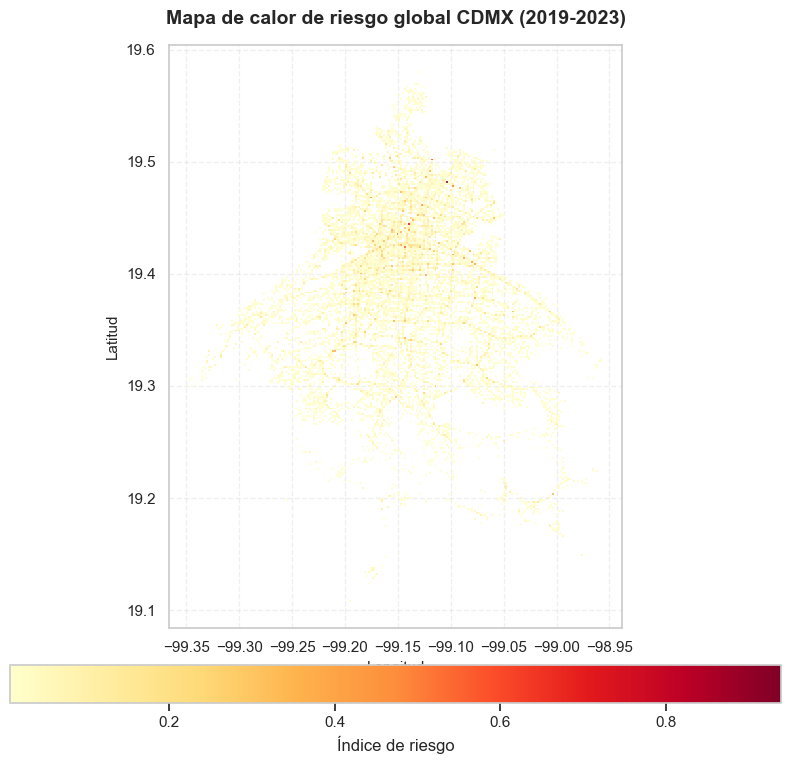


Mapa de calor con ponderación por año:


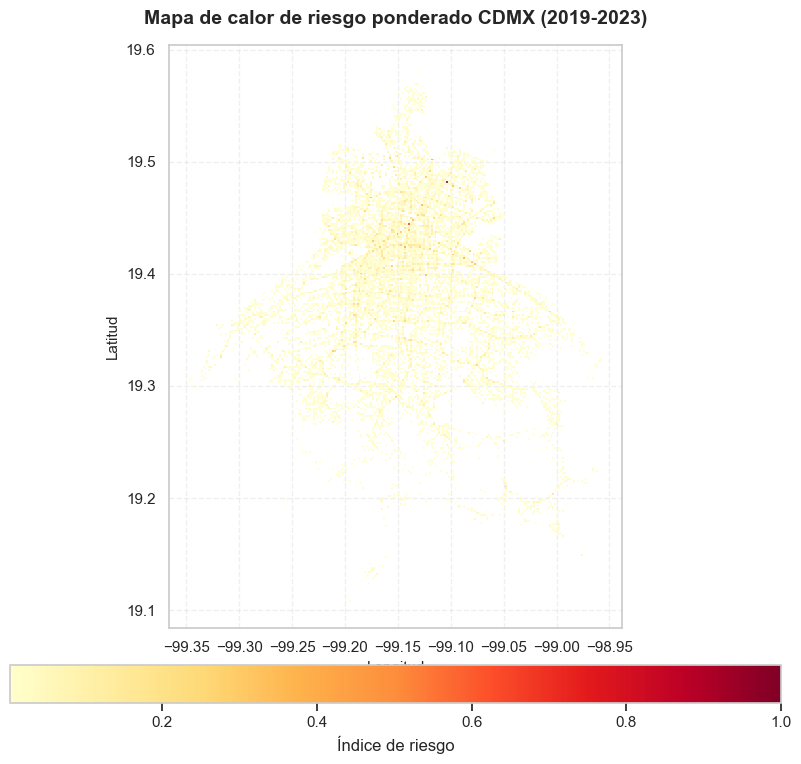

In [58]:
def plot_mapa_calor_global(grid_stats, titulo='Mapa de calor de riesgo global', 
                           figsize=(10, 8), cmap='YlOrRd'):
    """
    Genera mapa de calor global de riesgo con estilo unificado
    """
    grid_con_riesgo = grid_stats[grid_stats['indice_riesgo'] > 0].copy()
    
    # Proyectar a lat/lon para visualización
    grid_plot = grid_con_riesgo.to_crs(epsg=4326)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    grid_plot.plot(
        column='indice_riesgo',
        ax=ax,
        cmap=cmap,
        legend=True,
        alpha=0.8,
        edgecolor='none',
        legend_kwds={
            'label': 'Índice de riesgo',
            'orientation': 'horizontal',
            'shrink': 0.8,
            'pad': 0.05})
    
    ax.set_title(titulo, fontsize=14, weight='bold', pad=15)
    ax.set_xlabel('Longitud', fontsize=11)
    ax.set_ylabel('Latitud', fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()

# Mapa de calor global 2019-2023
print("Mapa de calor global 2019-2023:")
plot_mapa_calor_global(grid_2019_2023, 
                       titulo='Mapa de calor de riesgo global CDMX (2019-2023)')

print("\nMapa de calor con ponderación por año:")
plot_mapa_calor_global(grid_ponderado_2019_2023,
                       titulo='Mapa de calor de riesgo ponderado CDMX (2019-2023)')

In [59]:
def obtener_top_zonas_peligrosas(grid_stats, acc_celdas, top_n=20):
    """
    Genera tabla de las zonas más peligrosas con información detallada
    """
    # Filtrar celdas con riesgo
    grid_con_riesgo = grid_stats[grid_stats['indice_riesgo'] > 0].copy()
    
    # Ordenar por índice de riesgo
    top_celdas = grid_con_riesgo.nlargest(top_n, 'indice_riesgo')
    
    # Proyectar a lat/lon para coordenadas
    top_celdas_latlon = top_celdas.to_crs(epsg=4326)
    
    # Obtener centroide de cada celda
    top_celdas_latlon['centroid'] = top_celdas_latlon.geometry.centroid
    top_celdas_latlon['latitud_celda'] = top_celdas_latlon['centroid'].y
    top_celdas_latlon['longitud_celda'] = top_celdas_latlon['centroid'].x
    
    # Calcular muertos y heridos por celda
    acc_stats = acc_celdas.groupby('cell_id').agg(
        muertos=('totmuertos', 'sum'),
        heridos=('totheridos', 'sum')).reset_index()
    
    # Unir con top celdas
    top_final = top_celdas_latlon.merge(acc_stats, on='cell_id', how='left').fillna(0)
    
    # Seleccionar columnas para tabla
    tabla = top_final[[
        'cell_id', 
        'latitud_celda', 
        'longitud_celda',
        'accidentes_totales',
        'muertos',
        'heridos',
        'severidad_total',
        'indice_riesgo']].copy()
    
    tabla['muertos'] = tabla['muertos'].astype(int)
    tabla['heridos'] = tabla['heridos'].astype(int)
    tabla['accidentes_totales'] = tabla['accidentes_totales'].astype(int)
    tabla['severidad_total'] = tabla['severidad_total'].astype(int)
    tabla['indice_riesgo'] = tabla['indice_riesgo'].round(3)
    
    tabla = tabla.rename(columns={
        'cell_id': 'ID_Celda',
        'latitud_celda': 'Latitud',
        'longitud_celda': 'Longitud',
        'accidentes_totales': 'Accidentes',
        'muertos': 'Muertos',
        'heridos': 'Heridos',
        'severidad_total': 'Severidad',
        'indice_riesgo': 'Índice_Riesgo'})
    
    return tabla

# Generar tabla top 20
print("Top 20 zonas más peligrosas en CDMX (2019-2023):\n")
top_20_zonas = obtener_top_zonas_peligrosas(
    grid_2019_2023, acc_celdas_2019_2023, top_n=20)
display(top_20_zonas)

Top 20 zonas más peligrosas en CDMX (2019-2023):



C:\Users\Jhoshua\AppData\Local\Temp\ipykernel_15864\2827076293.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top_celdas_latlon['centroid'] = top_celdas_latlon.geometry.centroid


,ID_Celda,Latitud,Longitud,Accidentes,Muertos,Heridos,Severidad,Índice_Riesgo
0,38837,19.481549,-99.103619,45,8,26,158,0.940
1,33095,19.444282,-99.139552,48,5,19,107,0.758
2,36561,19.501873,-99.117992,43,1,23,79,0.600
3,32511,19.423950,-99.143145,53,1,17,61,0.579
4,31374,19.435811,-99.150332,47,1,15,55,0.519
5,39693,19.478161,-99.098230,36,4,11,73,0.507
6,27389,19.467998,-99.175485,49,0,15,45,0.484
7,35107,19.461222,-99.126976,40,0,17,51,0.456
8,41371,19.413784,-99.087450,38,1,12,46,0.428
9,42513,19.410395,-99.080263,34,2,9,47,0.426


## Configuración unificada de visualizaciones

Parámetros comunes para mantener consistencia visual en todos los mapas.

In [60]:
# Configuración global de estilo para mapas
ESTILO_MAPAS = {
    'figsize': (10, 8),
    'cmap': 'YlOrRd',  # Esquema de color: amarillo (bajo) -> rojo (alto)
    'alpha': 0.8,
    'edgecolor': 'none',
    'titulo_fontsize': 14,
    'titulo_weight': 'bold',
    'label_fontsize': 11,
    'grid_alpha': 0.3,
    'grid_linestyle': '--'
}

# Aplicar configuración de matplotlib
plt.rcParams['figure.figsize'] = ESTILO_MAPAS['figsize']
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = ESTILO_MAPAS['titulo_fontsize']
plt.rcParams['axes.labelsize'] = ESTILO_MAPAS['label_fontsize']

print("Configuración de estilo aplicada:")
print(f"- Tamaño de figura: {ESTILO_MAPAS['figsize']}")
print(f"- Esquema de color: {ESTILO_MAPAS['cmap']}")
print(f"- Transparencia: {ESTILO_MAPAS['alpha']}")
print("\nTodos los mapas utilizarán esta configuración uniforme.")

Configuración de estilo aplicada:
- Tamaño de figura: (10, 8)
- Esquema de color: YlOrRd
- Transparencia: 0.8

Todos los mapas utilizarán esta configuración uniforme.


## Resumen del análisis completado

### Implementaciones realizadas

1. **Índice de riesgo normalizado**: Combinación ponderada de frecuencia (N), severidad (S) y fatalidad (F) con normalización min-max

2. **Análisis temporal**: 
   - Índices de riesgo por franja horaria (Madrugada, Mañana, Tarde, Noche)
   - Mapas comparativos de riesgo según hora del día

3. **Ponderación por año**: Esquema que da mayor peso a años recientes (2023: 0.30, 2022: 0.25, 2021: 0.20, 2020: 0.15, 2019: 0.10)

4. **Asignación a tramos de calle**: 
   - 32,139 accidentes asignados a 15,615 tramos únicos
   - Distancia promedio de asignación: ~2.8 metros
   - Estadísticas calculadas por tramo (severidad, muertos, heridos)

5. **Análisis detallado de tramos peligrosos**:
   - Distribución de accidentes por tramo
   - Top 30 tramos más peligrosos
   - Mapa de top 50 tramos con mayor severidad

6. **Visualizaciones unificadas**:
   - Mapa de calor global de riesgo por celdas
   - Mapa de calor con ponderación temporal
   - Mapa de tramos más peligrosos
   - Tabla Top 20 zonas más peligrosas
   - Configuración consistente de estilo en todos los mapas

### Archivos generados

- `ACCIDENTES_CON_TRAMOS_2019_2023.csv`: Dataset completo con asignación a tramos
- `STATS_POR_TRAMO_2019_2023.csv`: Estadísticas agregadas por tramo de calle

### Próximos pasos sugeridos

- Desarrollar módulo de ruteo seguro usando índices de riesgo por tramo
- Análisis por tipo de usuario (peatones, ciclistas, motociclistas)
- Mapas específicos por tipo de accidente y causa
- Validación cruzada con datos de infraestructura vial